In [1]:
# all codes come are changed based on LDR code.
import argparse
import torch.optim as optim
import os
import yaml
from mcrgan.default import _C as config
from mcrgan.default import update_config
import torch
from mcrgan.trainer import MCRTrainer
from mcrgan.datasets import get_dataloader
from mcrgan.models import get_models
from mcrgan.models import get_BNN_models
from mcrgan.models import get_noise
from mcrgan.models import DiscriminatorMNIST
from mcrgan.models import weights_init_mnist_model_noise

import numpy as np
import torch
import argparse
from mcrgan.datasets import get_dataloader
from mcrgan.models import get_models
from mcrgan.default import _C as config
from mcrgan.default import update_config
from utils.utils import sort_dataset, compute_accuracy, extract_features
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm
import os
from mcrgan.loss import MCRGANloss
import random
#random.seed(0)

In [2]:
# data_preprocessing and parameters

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
DATASET = 'FMNIST'
ROOT    = 'pth/to/the/dataset'
BATCH_SIZE = 2048
WORKERS = 0
DATA_SAMPLE = 50000
LABEL = 1

dataloader, dataset = get_dataloader(
        data_name=DATASET,
        root=ROOT,
        batch_size=BATCH_SIZE,
        num_workers=WORKERS)


In [3]:
import collections

def get_netG(netD,netV,net_noise,radius=1):
    models = [netD, netV,net_noise]
    worker_state_dict = [x.state_dict() for x in models]
    weight_keys = list(worker_state_dict[0].keys())
    fed_state_dict = collections.OrderedDict()
    for key in weight_keys:
        fed_state_dict[key] = worker_state_dict[0][key] + radius*worker_state_dict[2][key]*torch.log(1+torch.exp(worker_state_dict[1][key]))
    return fed_state_dict

# new netG already optimized by adam and time learning rate, so we only using netG to update netV
def update_netV(netV,netG,net_noise,fed_state_dict,radius=1):
    models =[netV,netG,net_noise]
    worker_state_dict = [x.state_dict() for x in models]
    weight_keys = list(worker_state_dict[0].keys())
    update_dict = collections.OrderedDict()
    for key in weight_keys:
        update_dict[key] = worker_state_dict[0][key] - (worker_state_dict[1][key]-fed_state_dict[key])*(worker_state_dict[2][key]*radius)/torch.log(1+torch.exp(-worker_state_dict[0][key]))
    return update_dict
        

In [4]:
#models
# train hyperparameters, batch norm not used var
#store_Var = []
import time
from torch_mimicry.training import scheduler, logger, metric_log

from test_acc import nearsub
import numpy as np
import torch
import argparse
from mcrgan.datasets import get_dataloader
from mcrgan.models import get_models
from mcrgan.default import _C as config
from mcrgan.default import update_config
from utils.utils import sort_dataset, compute_accuracy, extract_features2
from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from tqdm import tqdm
import os

start_time = time.time()
#global_step = 0
num_steps = 500
n_dis = 1
n_dis2 = 1
numclasses =10
lr1 = 1e-3
lr2 = 1e-3
log_data = metric_log.MetricLog()
data_time = time.time()
iter_dataloader = iter(dataloader)
data, label = next(iter_dataloader)
data_time = time.time() - data_time
real_cpu = data.to(device)
real_label = label.clone().detach()

netD, netG, netV = get_BNN_models(DATASET, device, LABEL)
net_noise = get_noise(DATASET, device, LABEL)
fed_state_dict = get_netG(netD,netV,net_noise)
netG.load_state_dict(fed_state_dict)
optD = optim.Adam(netD.parameters(), lr1, betas=(0.5, 0.999))
optG = optim.Adam(netG.parameters(), lr2, betas=(0.5, 0.999))

Acc_results_D = []
Acc_results_G = []




transform = transforms.Compose(
            [transforms.Resize(32),
             transforms.ToTensor(),
             transforms.Normalize(0.5, 0.5)])

trainset = datasets.FashionMNIST(root=ROOT, train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root=ROOT, train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(
        testset, batch_size=DATA_SAMPLE, shuffle=False, num_workers=WORKERS)

trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=DATA_SAMPLE, shuffle=False, num_workers=WORKERS)
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")
n_comp = 10


In [5]:
netD, netG, netV

(DataParallel(
   (module): DiscriminatorMNIST_nz64(
     (main): Sequential(
       (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): LeakyReLU(negative_slope=0.2, inplace=True)
       (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (3): LeakyReLU(negative_slope=0.2, inplace=True)
       (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (5): LeakyReLU(negative_slope=0.2, inplace=True)
       (6): Conv2d(256, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
       (7): Flatten(start_dim=1, end_dim=-1)
     )
   )
 ),
 DataParallel(
   (module): DiscriminatorMNIST_nz64(
     (main): Sequential(
       (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (1): LeakyReLU(negative_slope=0.2, inplace=True)
       (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
       (3): LeakyReLU(negative_s

In [6]:
net_noise

DataParallel(
  (module): DiscriminatorMNIST_nz64(
    (main): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): LeakyReLU(negative_slope=0.2, inplace=True)
      (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (3): LeakyReLU(negative_slope=0.2, inplace=True)
      (4): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (5): LeakyReLU(negative_slope=0.2, inplace=True)
      (6): Conv2d(256, 64, kernel_size=(4, 4), stride=(1, 1), bias=False)
      (7): Flatten(start_dim=1, end_dim=-1)
    )
  )
)

In [7]:
# golden search algorithm to determined the radius of the sample ball, due to traditional updating netV is too slow
# no meaning for n_dis =2 for our case, just to have output for every update
# sample too much would arise cuda memory error
def gs_radius(radius1,radius2,netD,real_cpu,real_label,tor=1e-3,n_dis=2,lam=0.618,mode=1,gam3=1):
    mcr_gan_loss=MCRGANloss(gam1=1., gam2=1., gam3=gam3, eps=0.5, numclasses=numclasses, mode=11, rho=None)
    #optG = optim.Adam(netG.parameters(), lr2, betas=(0.5, 0.999))
    
    Z = netD(real_cpu)
    net_noise = get_noise(DATASET, device, LABEL)
    err1 = 0
    err2 = 1000
    while abs(err1 - err2)> tor or abs(radius1-radius2)>tor:
        a1 = radius2 - lam*(radius2-radius1)
        a2 = radius1 + lam*(radius2-radius1)
        fed_state_dict = get_netG(netD,netV,net_noise,a1)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errG1, errG_EC1 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
        err1 = errG1
        
        fed_state_dict = get_netG(netD,netV,net_noise,a2)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errG2, errG_EC2 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
        err2 = errG2
        
        if err1 > err2:
            radius1 = a1
            a1 = a2
            err1 = err2
            a2 = radius1 + lam*(radius2-radius1)
            fed_state_dict = get_netG(netD,netV,net_noise,a2)
            netG.load_state_dict(fed_state_dict)
            Z_bar = netG(real_cpu)
            errG2, errG_EC2 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
            err2 = errG2
            #print('r1',radius1)
            #print(errG2, errG_EC2)
        else:
            radius2 = a2
            a2 = a1
            a1 = radius2 - lam*(radius2-radius1)
            fed_state_dict = get_netG(netD,netV,net_noise,a1)
            netG.load_state_dict(fed_state_dict)
            Z_bar = netG(real_cpu)
            errG1, errG_EC1 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
            err1 = errG1
            #print('r2',radius2)
            #print(errG1, errG_EC1)
         
    return radius1,radius2

In [8]:
# golden search algorithm to determined the radius of the sample ball, due to traditional updating netV is too slow
# no meaning for n_dis =2 for our case, just to have output for every update
# sample too much would arise cuda memory error
def gs_radius_val(radius1,radius2,netD,real_cpu,real_label,tor=1e-3,n_dis=2,lam=0.618,mode=1,gam3=1):
    mcr_gan_loss=MCRGANloss(gam1=1., gam2=1., gam3=gam3, eps=0.5, numclasses=numclasses, mode=11, rho=None)
    #optG = optim.Adam(netG.parameters(), lr2, betas=(0.5, 0.999))
    n_comp = 10
    Z = netD(real_cpu)
    net_noise = get_noise(DATASET, device, LABEL)
    err1 = 0
    err2 = 1000
    while abs(err1 - err2)> tor or abs(radius1-radius2)>tor:
        a1 = radius2 - lam*(radius2-radius1)
        a2 = radius1 + lam*(radius2-radius1)
        fed_state_dict = get_netG(netD,netV,net_noise,a1)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errG1, errG_EC1 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
        err1 = errG1
        
        fed_state_dict = get_netG(netD,netV,net_noise,a2)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errG2, errG_EC2 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
        err2 = errG2
        
        if err1 > err2:
            radius1 = a1
            a1 = a2
            err1 = err2
            a2 = radius1 + lam*(radius2-radius1)
            fed_state_dict = get_netG(netD,netV,net_noise,a2)
            netG.load_state_dict(fed_state_dict)
            Z_bar = netG(real_cpu)
            errG2, errG_EC2 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
            err2 = errG2
            #print('r1',radius1)
            #print(errG2, errG_EC2)
        else:
            radius2 = a2
            a2 = a1
            a1 = radius2 - lam*(radius2-radius1)
            fed_state_dict = get_netG(netD,netV,net_noise,a1)
            netG.load_state_dict(fed_state_dict)
            Z_bar = netG(real_cpu)
            errG1, errG_EC1 = mcr_gan_loss(Z, Z_bar, real_label, n_dis2 - 1, n_dis2)
            err1 = errG1
            #print('r2',radius2)
            #print(errG1, errG_EC1)
            
    fed_state_dict = get_netG(netD,netV,net_noise,radius1)
    netG.load_state_dict(fed_state_dict)
    Z_bar = netG(real_cpu)
    
    
    corr_mean = np.zeros([n_comp,n_comp])
    corr_abs_mean = np.zeros([n_comp,n_comp])
    corr_min  = np.zeros([n_comp,n_comp])
    corr_max  = np.zeros([n_comp,n_comp])

    for i in range(10):
        for j in range(10):
            if i >= j :
                # change to 150 fit FMNIST data
                similarity_matrix = torch.nn.functional.cosine_similarity(Z_bar[label==i][0:150], Z_bar[label==j][0:150])
                temp_mean = torch.mean(similarity_matrix)
                temp_min = torch.min(similarity_matrix)
                temp_max = torch.max(similarity_matrix)
                temp_abs_mean = torch.mean(abs(similarity_matrix))

                corr_mean[i][j] = temp_mean
                corr_abs_mean[i][j] = temp_abs_mean
                corr_min[i][j]  = temp_min
                corr_max[i][j]  = temp_max

                corr_mean[j][i] = corr_mean[i][j]
                corr_abs_mean[j][i] = corr_abs_mean[i][j]
                corr_min[j][i] = corr_min[i][j]
                corr_max[j][i] = corr_max[i][j]
                
    corr_whole = np.zeros([4*n_comp,n_comp])
    corr_whole[0:10][:] =  corr_mean
    corr_whole[10:20][:] = corr_abs_mean
    corr_whole[20:30][:] = corr_min
    corr_whole[30:40][:] = corr_max
    
    
    fed_state_dict = get_netG(netD,netV,net_noise,radius1)
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    acc_val = count/10000
    print('NetG_fixDwith radius',radius1,acc_val)

         
    return radius1,radius2,corr_whole,acc_val

In [9]:
# fixed radius case, due to this requires more steps to go to about -200 then set 1500 epoches
mean_V = []
n_dis2 = 1
n_dis = 1
mode = 1
gam3 = 1
mcr_gan_loss = MCRGANloss(gam1=1., gam2=1., gam3=gam3, eps=0.5, numclasses=numclasses, mode=mode, rho=None)
loss_V = 0
last_V = -1000
num_steps = 500
lr1 = 1e-3
lr2 = 1e-3
optD = optim.Adam(netD.parameters(), lr1, betas=(0.5, 0.999))
optG = optim.Adam(netG.parameters(), lr2, betas=(0.5, 0.999))
meanV_sum = []
radius_list = []
radius = 0
for epoch in range(num_steps):

    for i in range(n_dis):
        netD.zero_grad()
        optD.zero_grad()
        Z = netD(real_cpu)
        net_noise = get_noise(DATASET, device, LABEL)
        #radius,_ = gs_radius(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
        #radius_list.append(radius)
        #print(radius)
        fed_state_dict = get_netG(netD,netV,net_noise,radius)
        netG.load_state_dict(fed_state_dict)
        Z_bar = netG(real_cpu)
        errD, errD_EC = mcr_gan_loss(Z, Z_bar, real_label, 1, n_dis)
        print(errD, errD_EC)
        errD.backward()
        optD.step()

    #print(meanV_num)
    #print(tempV)
    
    

tensor(-6.5862, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-3.2931, device='cuda:0', grad_fn=<NegBackward0>), tensor(-3.2931, device='cuda:0', grad_fn=<NegBackward0>), tensor(-7.6294e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-4.1605, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-2.0803, device='cuda:0', grad_fn=<NegBackward0>), tensor(-2.0803, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-8.4882, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-4.2441, device='cuda:0', grad_fn=<NegBackward0>), tensor(-4.2441, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-11.1146, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-5.5573, device='cuda:0', grad_fn=<NegBackward0>), tensor(-5.5573, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-12.5261, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-6.2631, device=

tensor(-31.7837, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-15.8919, device='cuda:0', grad_fn=<NegBackward0>), tensor(-15.8919, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-32.1341, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-16.0671, device='cuda:0', grad_fn=<NegBackward0>), tensor(-16.0671, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-32.6096, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-16.3048, device='cuda:0', grad_fn=<NegBackward0>), tensor(-16.3048, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-33.3001, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-16.6501, device='cuda:0', grad_fn=<NegBackward0>), tensor(-16.6501, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-34.0703, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-17.03

tensor(-39.5448, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-19.7724, device='cuda:0', grad_fn=<NegBackward0>), tensor(-19.7724, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-39.3149, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-19.6574, device='cuda:0', grad_fn=<NegBackward0>), tensor(-19.6574, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-39.7326, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-19.8663, device='cuda:0', grad_fn=<NegBackward0>), tensor(-19.8663, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-39.9570, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-19.9785, device='cuda:0', grad_fn=<NegBackward0>), tensor(-19.9785, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-40.2064, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-20.1032, devi

tensor(-42.7939, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-21.3970, device='cuda:0', grad_fn=<NegBackward0>), tensor(-21.3970, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-42.8084, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-21.4042, device='cuda:0', grad_fn=<NegBackward0>), tensor(-21.4042, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-42.8745, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-21.4372, device='cuda:0', grad_fn=<NegBackward0>), tensor(-21.4372, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-43.4813, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-21.7406, device='cuda:0', grad_fn=<NegBackward0>), tensor(-21.7406, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-43.5699, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-21.78

tensor(-45.0280, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-22.5140, device='cuda:0', grad_fn=<NegBackward0>), tensor(-22.5140, device='cuda:0', grad_fn=<NegBackward0>), tensor(7.6294e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-45.3487, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-22.6743, device='cuda:0', grad_fn=<NegBackward0>), tensor(-22.6743, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-45.2688, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-22.6344, device='cuda:0', grad_fn=<NegBackward0>), tensor(-22.6344, device='cuda:0', grad_fn=<NegBackward0>), tensor(-7.6294e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-44.9641, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-22.4820, device='cuda:0', grad_fn=<NegBackward0>), tensor(-22.4820, device='cuda:0', grad_fn=<NegBackward0>), tensor(-7.6294e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-44.8486, device='cuda:0', grad_fn=<NegBackward

tensor(-46.1734, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-23.0867, device='cuda:0', grad_fn=<NegBackward0>), tensor(-23.0867, device='cuda:0', grad_fn=<NegBackward0>), tensor(-7.6294e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-46.5905, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-23.2952, device='cuda:0', grad_fn=<NegBackward0>), tensor(-23.2952, device='cuda:0', grad_fn=<NegBackward0>), tensor(7.6294e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-46.4974, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-23.2487, device='cuda:0', grad_fn=<NegBackward0>), tensor(-23.2487, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-46.3542, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-23.1771, device='cuda:0', grad_fn=<NegBackward0>), tensor(-23.1771, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-46.4159, device='cuda:0', grad_fn=<NegBackward0>) [tens

tensor(-47.2340, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-23.6170, device='cuda:0', grad_fn=<NegBackward0>), tensor(-23.6170, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-47.0765, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-23.5382, device='cuda:0', grad_fn=<NegBackward0>), tensor(-23.5382, device='cuda:0', grad_fn=<NegBackward0>), tensor(-7.6294e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-47.1571, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-23.5785, device='cuda:0', grad_fn=<NegBackward0>), tensor(-23.5785, device='cuda:0', grad_fn=<NegBackward0>), tensor(7.6294e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-47.2644, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-23.6322, device='cuda:0', grad_fn=<NegBackward0>), tensor(-23.6322, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-47.3036, device='cuda:0', grad_fn=<NegBackward0>) [tens

tensor(-47.4618, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-23.7309, device='cuda:0', grad_fn=<NegBackward0>), tensor(-23.7309, device='cuda:0', grad_fn=<NegBackward0>), tensor(7.6294e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-47.6882, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-23.8441, device='cuda:0', grad_fn=<NegBackward0>), tensor(-23.8441, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-47.8343, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-23.9172, device='cuda:0', grad_fn=<NegBackward0>), tensor(-23.9172, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-47.9136, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-23.9568, device='cuda:0', grad_fn=<NegBackward0>), tensor(-23.9568, device='cuda:0', grad_fn=<NegBackward0>), tensor(-7.6294e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-47.8186, device='cuda:0', grad_fn=<NegBackward0>) [tens

tensor(-48.1773, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.0887, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.0887, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-48.1906, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.0953, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.0953, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-48.4268, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.2134, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.2134, device='cuda:0', grad_fn=<NegBackward0>), tensor(-7.6294e-06, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-48.4927, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.2464, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.2464, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-48.4092, device='cuda:0', grad_fn=<NegBackward0>) [tens

tensor(-48.7320, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.3660, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.3660, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-48.6619, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.3309, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.3309, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-48.6335, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.3168, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.3168, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-48.6304, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.3152, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.3152, device='cuda:0', grad_fn=<NegBackward0>), tensor(2.2888e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-48.6581, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.32

tensor(-49.1042, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.5521, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.5521, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-49.0911, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.5456, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.5456, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-49.1762, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.5881, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.5881, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-49.1976, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.5988, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.5988, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-49.1355, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.5677, devi

tensor(-49.2613, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.6306, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.6306, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-49.2227, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.6114, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.6114, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-49.3169, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.6584, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.6584, device='cuda:0', grad_fn=<NegBackward0>), tensor(-1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-49.4234, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.7117, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.7117, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-49.5077, device='cuda:0', grad_fn=<NegBackward0>) [tens

tensor(-49.7733, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.8867, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.8867, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-49.8369, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.9185, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.9185, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-49.8572, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.9286, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.9286, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-49.8184, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.9092, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.9092, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-49.7586, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.8793, devi

tensor(-49.8896, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.9448, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.9448, device='cuda:0', grad_fn=<NegBackward0>), tensor(1.5259e-05, device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-49.9022, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.9511, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.9511, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-49.8979, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.9489, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.9489, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-49.8770, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.9385, device='cuda:0', grad_fn=<NegBackward0>), tensor(-24.9385, device='cuda:0', grad_fn=<NegBackward0>), tensor(0., device='cuda:0', grad_fn=<AddBackward0>)]
tensor(-49.8308, device='cuda:0', grad_fn=<NegBackward0>) [tensor(-24.91

In [10]:
#10/256, 9/1000 for 200 epoches -196.2230, resample again under load case to avoid wrong.
r_records = np.zeros(1000)
for i in range(1000):
    radius_bar,_ = gs_radius(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
    r_records[i] = radius_bar
    print(radius_bar)

0.01151705392484554
0.18929228898190198
0.18279841477533196
0.16951235032244225
0.19257697975116378
0.18293165331327502
0.10198027943837862
0.1772335153067981
0.16072005944267326
0.16304862695038164
0.13832063838331288
0.00012000514272956238
0.16132438614868025
0.15293291886702945
0.15276399089926013
0.15587974994126605
0.00037274781689694114
4.768355405348494e-05
0.12767135913491529
0.00014721428772655374
0.18357601318919792
0.17512184897408578
0.0002732277633727709
0.19678743370203133
2.533492265816534e-05
0.1635474748847914
4.5836695423240294e-05
0.21126001000946767
0.19125098464287568
0.1549142162133174
0.12707203037957662
0.18558503793962838
0.15794241131887485
0.14316817483698
0.16787627012847853
0.12694466370718413
0.13023146700610064
0.16827401221814797
3.316875271233461e-05
0.09055052436039768
0.1691001807417572
0.22498715961852764
0.0001863649704039834
0.14749803324683589
0.00028105751473175665
0.18994977351806777
0.00034440620849677644
0.14345416103622166
5.850367537049995e-

0.22083673420971706
0.19163858361313557
0.15817662518506284
0.153203453968677
0.15088750632313772
0.17644281455349736
0.00020202818446982818
0.12788265829808518
0.1807512514016188
0.18492028564590246
0.1591068568704932
0.19638112303027686
0.13092186948319645
7.900760142188806e-05
0.16712387677653787
8.684647393809926e-05
7.828788595339712e-06
0.09751790654576206
0.00013268316936133954
0.14655505283102574
0.2306415442631804
5.850367537049995e-05
2.9900022554865243e-06
2.533648052814273e-05
0.14699921423968665
0.2035502093837572
0.17763603642280812
0.00034256558242283834
9.880721841034994e-05
0.00012001270582522773
2.9900022554865243e-06
0.12023858118782717
0.0004957897641829892
0.17827454212160343
8.684647393809926e-05
0.17634997197203173
0.12988694761248695
0.1768010854777923
0.2053425564194848
0.19645704076341414
0.16896932981224394
0.1939873898358435
0.14303546526466707
0.00023519693718216276
0.20887954887861923
0.12317798533495106
0.1645633698337568
0.16405303464621399
0.18015854623

0.00019604721726837913
0.12291278253415071
0.15705140761406203
0.0001531952549280028
0.14303984164929295
0.14921539575281406
0.15514582599768367
0.00018152581628841746
0.12517622942653045
0.17786892397238813
0.1896959160291824
0.14949965189255923
0.13006066600097954
5.36670418885574e-05
0.00013268220659769353
0.21069736038337292
0.18993417691410325
0.0001483463834271843
0.17497677484253385
0.00012001522665043386
6.448991174457156e-05
0.1945711088520113
7.416785219999072e-05
0.1544329505370232
0.16526156960820004
0.00021469768505071125
0.130354755077489
5.850523324047734e-05
0.12840388764827165
8.683639001722778e-05
1.2667942710905685e-05
0.18787159653096397
4.2845362701565e-05
0.00014835706357608285
0.1589570733372035
0.13122800415307032
0.17367013621026292
0.14867959938464329
4.5836695423240294e-05
0.15684626547380726
0.0001375213607132595
0.18721988936215872
0.17859664457478536
0.00033957498517941855
0.14685847039196828
4.0997541307674324e-05
0.0004421120429572245
0.18387225584059433

In [11]:
np.histogram(r_records)

(array([997,   0,   0,   0,   0,   0,   0,   0,   0,   3], dtype=int64),
 array([ 0.        ,  9.99787681, 19.99575362, 29.99363042, 39.99150723,
        49.98938404, 59.98726085, 69.98513766, 79.98301447, 89.98089127,
        99.97876808]))

In [12]:
#acc at first for NetD
NetD_acc = 0
train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(testloader, netD, netG)

test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netD, netG)


print("----------------------------")
print("Train_z, Test_z")
nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

#acc at first for NetD
from sklearn.neighbors import KNeighborsClassifier 
knn= KNeighborsClassifier(n_neighbors=10) 

knn.fit(train_Z,train_labels) 
knn.score(test_Z,test_labels) 
 
y_predict = knn.predict(test_Z) 

count =0
for k in range(10000):
    if y_predict[k] == test_labels[k]:
        count +=1
        
NetD_acc = count/10000
print('NetD, Acc at first', NetD_acc)
Acc_results_D.append(count/10000)

#acc at first for NetG
train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

print("----------------------------")
print("Train_z, Test_z")
nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)


#acc at first
from sklearn.neighbors import KNeighborsClassifier 
knn= KNeighborsClassifier(n_neighbors=10) 

knn.fit(train_Z,train_labels) 
knn.score(test_Z,test_labels) 
 
y_predict = knn.predict(test_Z) 

count =0
for k in range(10000):
    if y_predict[k] == test_labels[k]:
        count +=1
print('NetG, Acc at first',count/10000)
Acc_results_G.append(count/10000)


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8333
SVD: 0.8315
NetD, Acc at first 0.8595


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8197
SVD: 0.8234
NetG, Acc at first 0.8566


In [13]:
#robust testing
r_list = [0,0.1,0.2,0.5,1,2,3,4,6,8,10]
sample_num = 20
acc_record = np.zeros([4,20])


In [14]:
# sample 20 times of NetG at final radius, NetD is fixed, length 0.1,0.2,0.5,1,2,4,6,8,10,15,20
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample = []
for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[1])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample.append(count/10000)

print(max(Acc_results_G_sample),min(Acc_results_G_sample),np.mean(Acc_results_G_sample),np.var(Acc_results_G_sample))


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8208
SVD: 0.8235
NetG_fixD, Acc at sample 1 0.8572


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8209
SVD: 0.8233
NetG_fixD, Acc at sample 2 0.8574


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.8190999999999999
SVD: 0.8220000000000001
NetG_fixD, Acc at sample 3 0.8579


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8196
SVD: 0.8233
NetG_fixD, Acc at sample 4 0.8578


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8195
SVD: 0.8218
NetG_fixD, Acc at sample 5 0.8571


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.8190999999999999
SVD: 0.8220000000000001
NetG_fixD, Acc at sample 6 0.8578


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8197
SVD: 0.8202
NetG_fixD, Acc at sample 7 0.8581


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8199
SVD: 0.8225
NetG_fixD, Acc at sample 8 0.8572


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.8193
SVD: 0.8239
NetG_fixD, Acc at sample 9 0.8578


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8202
SVD: 0.8236
NetG_fixD, Acc at sample 10 0.8568


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8202
SVD: 0.8237
NetG_fixD, Acc at sample 11 0.8565


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.8216
SVD: 0.8210999999999999
NetG_fixD, Acc at sample 12 0.8565


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8214
SVD: 0.8216
NetG_fixD, Acc at sample 13 0.8573


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8197
SVD: 0.8217
NetG_fixD, Acc at sample 14 0.8587


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8213
SVD: 0.8239
NetG_fixD, Acc at sample 15 0.8576


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8197
SVD: 0.8225
NetG_fixD, Acc at sample 16 0.8575


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8197
SVD: 0.8248
NetG_fixD, Acc at sample 17 0.8579


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.8201
SVD: 0.823
NetG_fixD, Acc at sample 18 0.8571


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8204
SVD: 0.8218
NetG_fixD, Acc at sample 19 0.8561


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8208
SVD: 0.8225
NetG_fixD, Acc at sample 20 0.857
0.8587 0.8561 0.857365 3.642750000000025e-07


In [15]:
acc_record[0][0] = NetD_acc
acc_record[1][0] = NetD_acc
acc_record[2][0] = NetD_acc
acc_record[3][0] = 0
acc_record[0][1] = np.mean(Acc_results_G_sample)
acc_record[1][1] = max(Acc_results_G_sample)
acc_record[2][1] = min(Acc_results_G_sample)
acc_record[3][1] = np.var(Acc_results_G_sample)

In [16]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample2 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[2])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample2.append(count/10000)
    
print(max(Acc_results_G_sample2),min(Acc_results_G_sample2),np.mean(Acc_results_G_sample2),np.var(Acc_results_G_sample2))
acc_record[0][2] = np.mean(Acc_results_G_sample2)
acc_record[1][2] = max(Acc_results_G_sample2)
acc_record[2][2] = min(Acc_results_G_sample2)
acc_record[3][2] = np.var(Acc_results_G_sample2)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.8202
SVD: 0.8224
NetG_fixD, Acc at sample 1 0.8576


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


----------------------------
Train_z, Test_z
PCA: 0.8213
SVD: 0.8260000000000001
NetG_fixD, Acc at sample 2 0.8576


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8229
SVD: 0.8248
NetG_fixD, Acc at sample 3 0.8571


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8228
SVD: 0.8216
NetG_fixD, Acc at sample 4 0.856


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.8204
SVD: 0.8212
NetG_fixD, Acc at sample 5 0.8578


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8202
SVD: 0.8190999999999999
NetG_fixD, Acc at sample 6 0.8566


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8210999999999999
SVD: 0.8239
NetG_fixD, Acc at sample 7 0.8577


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.8214
SVD: 0.821
NetG_fixD, Acc at sample 8 0.8565


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8194
SVD: 0.8209
NetG_fixD, Acc at sample 9 0.8558


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.8214
SVD: 0.8206
NetG_fixD, Acc at sample 10 0.8579


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8215
SVD: 0.8248
NetG_fixD, Acc at sample 11 0.8574


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8203
SVD: 0.8215
NetG_fixD, Acc at sample 12 0.8558


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8187
SVD: 0.823
NetG_fixD, Acc at sample 13 0.8586


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8193
SVD: 0.8208
NetG_fixD, Acc at sample 14 0.8567


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.8188
SVD: 0.8241
NetG_fixD, Acc at sample 15 0.8568


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8206
SVD: 0.8246
NetG_fixD, Acc at sample 16 0.8561


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8212
SVD: 0.8218
NetG_fixD, Acc at sample 17 0.8566


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.8194
SVD: 0.8210999999999999
NetG_fixD, Acc at sample 18 0.8575


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8225
SVD: 0.825
NetG_fixD, Acc at sample 19 0.8572


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8199
SVD: 0.8242
NetG_fixD, Acc at sample 20 0.8569
0.8586 0.8558 0.85701 5.539000000000107e-07


In [17]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample3 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[3])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample3.append(count/10000)
    
print(max(Acc_results_G_sample3),min(Acc_results_G_sample3),np.mean(Acc_results_G_sample3),np.var(Acc_results_G_sample3))
acc_record[0][3] = np.mean(Acc_results_G_sample3)
acc_record[1][3] = max(Acc_results_G_sample3)
acc_record[2][3] = min(Acc_results_G_sample3)
acc_record[3][3] = np.var(Acc_results_G_sample3)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


----------------------------
Train_z, Test_z
PCA: 0.8185
SVD: 0.8209
NetG_fixD, Acc at sample 1 0.8568


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.8251999999999999
SVD: 0.8263
NetG_fixD, Acc at sample 2 0.8555


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8196
SVD: 0.8215
NetG_fixD, Acc at sample 3 0.8565


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8239
SVD: 0.823
NetG_fixD, Acc at sample 4 0.8588


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8228
SVD: 0.8271999999999999
NetG_fixD, Acc at sample 5 0.8545


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8188
SVD: 0.8203
NetG_fixD, Acc at sample 6 0.8544


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8212
SVD: 0.8226
NetG_fixD, Acc at sample 7 0.8559


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8228
SVD: 0.8235
NetG_fixD, Acc at sample 8 0.8566


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.8224
SVD: 0.8210999999999999
NetG_fixD, Acc at sample 9 0.8572


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8207
SVD: 0.8223
NetG_fixD, Acc at sample 10 0.8569


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8215
SVD: 0.8201
NetG_fixD, Acc at sample 11 0.8586


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8198
SVD: 0.8199
NetG_fixD, Acc at sample 12 0.8583


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8170999999999999
SVD: 0.8181
NetG_fixD, Acc at sample 13 0.8561


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.8198
SVD: 0.8222
NetG_fixD, Acc at sample 14 0.8565


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8184
SVD: 0.8194
NetG_fixD, Acc at sample 15 0.8561


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.8201
SVD: 0.8198
NetG_fixD, Acc at sample 16 0.8565


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8205
SVD: 0.8229
NetG_fixD, Acc at sample 17 0.8553


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8182
SVD: 0.8208
NetG_fixD, Acc at sample 18 0.858


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.8208
SVD: 0.8203
NetG_fixD, Acc at sample 19 0.8573


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8227
SVD: 0.8218
NetG_fixD, Acc at sample 20 0.8548
0.8588 0.8544 0.85653 1.5490999999999775e-06


In [18]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample4 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[4])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample4.append(count/10000)
    
print(max(Acc_results_G_sample4),min(Acc_results_G_sample4),np.mean(Acc_results_G_sample4),np.var(Acc_results_G_sample4))
acc_record[0][4] = np.mean(Acc_results_G_sample4)
acc_record[1][4] = max(Acc_results_G_sample4)
acc_record[2][4] = min(Acc_results_G_sample4)
acc_record[3][4] = np.var(Acc_results_G_sample4)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8173
SVD: 0.8190999999999999
NetG_fixD, Acc at sample 1 0.8497


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8202
SVD: 0.8234
NetG_fixD, Acc at sample 2 0.8524


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8234
SVD: 0.8245
NetG_fixD, Acc at sample 3 0.8522


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.817
SVD: 0.8246
NetG_fixD, Acc at sample 4 0.8503


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8185
SVD: 0.8190999999999999
NetG_fixD, Acc at sample 5 0.853


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8207
SVD: 0.8215
NetG_fixD, Acc at sample 6 0.8534


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.8176
SVD: 0.8207
NetG_fixD, Acc at sample 7 0.8534


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8233
SVD: 0.8244
NetG_fixD, Acc at sample 8 0.8519


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.821
SVD: 0.8196
NetG_fixD, Acc at sample 9 0.8493


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.8238
SVD: 0.8279
NetG_fixD, Acc at sample 10 0.8522


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8242
SVD: 0.823
NetG_fixD, Acc at sample 11 0.8515


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8206
SVD: 0.8226
NetG_fixD, Acc at sample 12 0.8516


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8161
SVD: 0.8178
NetG_fixD, Acc at sample 13 0.8495


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8230999999999999
SVD: 0.8271
NetG_fixD, Acc at sample 14 0.8531


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8226
SVD: 0.8218
NetG_fixD, Acc at sample 15 0.8532


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.8196
SVD: 0.8189
NetG_fixD, Acc at sample 16 0.8528


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8223
SVD: 0.8230999999999999
NetG_fixD, Acc at sample 17 0.8515


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8207
SVD: 0.8239
NetG_fixD, Acc at sample 18 0.8531


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.8193
SVD: 0.8222
NetG_fixD, Acc at sample 19 0.8519


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


----------------------------
Train_z, Test_z
PCA: 0.8213
SVD: 0.8180000000000001
NetG_fixD, Acc at sample 20 0.8505
0.8534 0.8493 0.851825 1.6848749999999764e-06


In [19]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample5 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[5])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample5.append(count/10000)
    
print(max(Acc_results_G_sample5),min(Acc_results_G_sample5),np.mean(Acc_results_G_sample5),np.var(Acc_results_G_sample5))
acc_record[0][5] = np.mean(Acc_results_G_sample5)
acc_record[1][5] = max(Acc_results_G_sample5)
acc_record[2][5] = min(Acc_results_G_sample5)
acc_record[3][5] = np.var(Acc_results_G_sample5)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8145
SVD: 0.8153
NetG_fixD, Acc at sample 1 0.8396


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


----------------------------
Train_z, Test_z
PCA: 0.8168
SVD: 0.8137
NetG_fixD, Acc at sample 2 0.8374


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8156
SVD: 0.8148
NetG_fixD, Acc at sample 3 0.8337


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8208
SVD: 0.8180000000000001
NetG_fixD, Acc at sample 4 0.8395


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


----------------------------
Train_z, Test_z
PCA: 0.8182
SVD: 0.8153
NetG_fixD, Acc at sample 5 0.8375


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.8212
SVD: 0.8180000000000001
NetG_fixD, Acc at sample 6 0.8398


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8164
SVD: 0.8174
NetG_fixD, Acc at sample 7 0.8391


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.8195
SVD: 0.8209
NetG_fixD, Acc at sample 8 0.8377


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8213
SVD: 0.8228
NetG_fixD, Acc at sample 9 0.8385


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8114
SVD: 0.8095
NetG_fixD, Acc at sample 10 0.8373


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8129
SVD: 0.8145
NetG_fixD, Acc at sample 11 0.8365


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8147
SVD: 0.8150999999999999
NetG_fixD, Acc at sample 12 0.8392


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.8168
SVD: 0.8129
NetG_fixD, Acc at sample 13 0.8367


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8194
SVD: 0.8164
NetG_fixD, Acc at sample 14 0.8341


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.8195
SVD: 0.8160000000000001
NetG_fixD, Acc at sample 15 0.8384


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.8153
SVD: 0.8128
NetG_fixD, Acc at sample 16 0.8298


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8190999999999999
SVD: 0.8128
NetG_fixD, Acc at sample 17 0.8367


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


----------------------------
Train_z, Test_z
PCA: 0.8200000000000001
SVD: 0.8216
NetG_fixD, Acc at sample 18 0.8381


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.8087
SVD: 0.8061
NetG_fixD, Acc at sample 19 0.8375


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8257
SVD: 0.8210999999999999
NetG_fixD, Acc at sample 20 0.8394
0.8398 0.8298 0.8373250000000001 5.598875000000028e-06


In [20]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample6 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[6])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample6.append(count/10000)
    
print(max(Acc_results_G_sample6),min(Acc_results_G_sample6),np.mean(Acc_results_G_sample6),np.var(Acc_results_G_sample6))
acc_record[0][6] = np.mean(Acc_results_G_sample6)
acc_record[1][6] = max(Acc_results_G_sample6)
acc_record[2][6] = min(Acc_results_G_sample6)
acc_record[3][6] = np.var(Acc_results_G_sample6)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8068
SVD: 0.8061
NetG_fixD, Acc at sample 1 0.717


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.8054
SVD: 0.8031
NetG_fixD, Acc at sample 2 0.7376


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8007
SVD: 0.7962
NetG_fixD, Acc at sample 3 0.7499


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8017
SVD: 0.8029999999999999
NetG_fixD, Acc at sample 4 0.6187


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8044
SVD: 0.8023
NetG_fixD, Acc at sample 5 0.7353


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.7996
SVD: 0.7948999999999999
NetG_fixD, Acc at sample 6 0.6839


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.7924
SVD: 0.7904
NetG_fixD, Acc at sample 7 0.6822


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8023
SVD: 0.7989999999999999
NetG_fixD, Acc at sample 8 0.7523


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8001
SVD: 0.7927
NetG_fixD, Acc at sample 9 0.6935


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.7955
SVD: 0.7956
NetG_fixD, Acc at sample 10 0.6994


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8049999999999999
SVD: 0.7957
NetG_fixD, Acc at sample 11 0.7447


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.8033
SVD: 0.7987
NetG_fixD, Acc at sample 12 0.7653


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.7994
SVD: 0.798
NetG_fixD, Acc at sample 13 0.6834


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8063
SVD: 0.7995
NetG_fixD, Acc at sample 14 0.7386


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.8031
SVD: 0.8015
NetG_fixD, Acc at sample 15 0.7592


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8089999999999999
SVD: 0.8039000000000001
NetG_fixD, Acc at sample 16 0.7859


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.8048
SVD: 0.8003
NetG_fixD, Acc at sample 17 0.742


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.7945
SVD: 0.7932
NetG_fixD, Acc at sample 18 0.6775


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.7996
SVD: 0.7952
NetG_fixD, Acc at sample 19 0.7632


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.7899
SVD: 0.7853
NetG_fixD, Acc at sample 20 0.5655
0.7859 0.5655 0.714755 0.002715709475


In [21]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample7 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[7])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample7.append(count/10000)
    
print(max(Acc_results_G_sample7),min(Acc_results_G_sample7),np.mean(Acc_results_G_sample7),np.var(Acc_results_G_sample7))
acc_record[0][7] = np.mean(Acc_results_G_sample7)
acc_record[1][7] = max(Acc_results_G_sample7)
acc_record[2][7] = min(Acc_results_G_sample7)
acc_record[3][7] = np.var(Acc_results_G_sample7)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.7943
SVD: 0.7928
NetG_fixD, Acc at sample 1 0.3935


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.7916
SVD: 0.7834
NetG_fixD, Acc at sample 2 0.4601


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.7884
SVD: 0.7821
NetG_fixD, Acc at sample 3 0.2453


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


----------------------------
Train_z, Test_z
PCA: 0.7864
SVD: 0.7827999999999999
NetG_fixD, Acc at sample 4 0.3666


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.7879
SVD: 0.7907
NetG_fixD, Acc at sample 5 0.3643


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.7858
SVD: 0.7823
NetG_fixD, Acc at sample 6 0.4023


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.8008
SVD: 0.8009999999999999
NetG_fixD, Acc at sample 7 0.4908


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.7905
SVD: 0.7879
NetG_fixD, Acc at sample 8 0.4048


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.7955
SVD: 0.7916
NetG_fixD, Acc at sample 9 0.2479


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.7917
SVD: 0.7847
NetG_fixD, Acc at sample 10 0.3819


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.794
SVD: 0.7917
NetG_fixD, Acc at sample 11 0.3152


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.7784
SVD: 0.7799
NetG_fixD, Acc at sample 12 0.4236


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.7699
SVD: 0.7709
NetG_fixD, Acc at sample 13 0.2591


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.8
SVD: 0.7937
NetG_fixD, Acc at sample 14 0.373


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.7835
SVD: 0.7774
NetG_fixD, Acc at sample 15 0.1789


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.7894
SVD: 0.7912
NetG_fixD, Acc at sample 16 0.4606


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.7839
SVD: 0.7825
NetG_fixD, Acc at sample 17 0.3173


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.7914
SVD: 0.787
NetG_fixD, Acc at sample 18 0.3354


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.7934
SVD: 0.7884
NetG_fixD, Acc at sample 19 0.2479


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.7868999999999999
SVD: 0.7881
NetG_fixD, Acc at sample 20 0.3954
0.4908 0.1789 0.35319500000000004 0.0066476314750000005


In [22]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample8 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[8])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample8.append(count/10000)
    
print(max(Acc_results_G_sample8),min(Acc_results_G_sample8),np.mean(Acc_results_G_sample8),np.var(Acc_results_G_sample8))
acc_record[0][8] = np.mean(Acc_results_G_sample8)
acc_record[1][8] = max(Acc_results_G_sample8)
acc_record[2][8] = min(Acc_results_G_sample8)
acc_record[3][8] = np.var(Acc_results_G_sample8)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.7918000000000001
SVD: 0.7896
NetG_fixD, Acc at sample 1 0.1394


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.7775
SVD: 0.7731
NetG_fixD, Acc at sample 2 0.157


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.7822
SVD: 0.7771
NetG_fixD, Acc at sample 3 0.1326


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.7874
SVD: 0.7886
NetG_fixD, Acc at sample 4 0.1307


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.7897000000000001
SVD: 0.7912
NetG_fixD, Acc at sample 5 0.1851


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.48it/s]


----------------------------
Train_z, Test_z
PCA: 0.7857000000000001
SVD: 0.7812
NetG_fixD, Acc at sample 6 0.1154


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.7953
SVD: 0.7947
NetG_fixD, Acc at sample 7 0.0942


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.7885
SVD: 0.7857000000000001
NetG_fixD, Acc at sample 8 0.1506


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.7898000000000001
SVD: 0.7877000000000001
NetG_fixD, Acc at sample 9 0.1501


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.35it/s]


----------------------------
Train_z, Test_z
PCA: 0.7821
SVD: 0.781
NetG_fixD, Acc at sample 10 0.0954


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.7907
SVD: 0.7881
NetG_fixD, Acc at sample 11 0.1191


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.7888
SVD: 0.7897000000000001
NetG_fixD, Acc at sample 12 0.1138


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.7791
SVD: 0.7794
NetG_fixD, Acc at sample 13 0.1455


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.785
SVD: 0.7793
NetG_fixD, Acc at sample 14 0.1312


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.30it/s]


----------------------------
Train_z, Test_z
PCA: 0.7846
SVD: 0.7815
NetG_fixD, Acc at sample 15 0.1366


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.7836
SVD: 0.7809
NetG_fixD, Acc at sample 16 0.1041


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.7927
SVD: 0.7911
NetG_fixD, Acc at sample 17 0.1744


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.7829
SVD: 0.7835
NetG_fixD, Acc at sample 18 0.1764


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.7895
SVD: 0.788
NetG_fixD, Acc at sample 19 0.1237


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.7876
SVD: 0.7854
NetG_fixD, Acc at sample 20 0.14
0.1851 0.0942 0.135765 0.0006158782749999998


In [23]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample9 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[9])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample9.append(count/10000)
    
print(max(Acc_results_G_sample9),min(Acc_results_G_sample9),np.mean(Acc_results_G_sample9),np.var(Acc_results_G_sample9))
acc_record[0][9] = np.mean(Acc_results_G_sample9)
acc_record[1][9] = max(Acc_results_G_sample9)
acc_record[2][9] = min(Acc_results_G_sample9)
acc_record[3][9] = np.var(Acc_results_G_sample9)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.7821
SVD: 0.7784
NetG_fixD, Acc at sample 1 0.0899


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.7823
SVD: 0.778
NetG_fixD, Acc at sample 2 0.1088


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.32it/s]


----------------------------
Train_z, Test_z
PCA: 0.7893
SVD: 0.7844
NetG_fixD, Acc at sample 3 0.1249


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.7898000000000001
SVD: 0.7872
NetG_fixD, Acc at sample 4 0.1339


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.7922
SVD: 0.7885
NetG_fixD, Acc at sample 5 0.1107


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.36it/s]


----------------------------
Train_z, Test_z
PCA: 0.7877000000000001
SVD: 0.7792
NetG_fixD, Acc at sample 6 0.0983


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.7888999999999999
SVD: 0.7842
NetG_fixD, Acc at sample 7 0.0971


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.783
SVD: 0.7856
NetG_fixD, Acc at sample 8 0.1049


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.7844
SVD: 0.7834
NetG_fixD, Acc at sample 9 0.0799


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.7962
SVD: 0.7923
NetG_fixD, Acc at sample 10 0.0606


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.7851
SVD: 0.7853
NetG_fixD, Acc at sample 11 0.1124


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


----------------------------
Train_z, Test_z
PCA: 0.785
SVD: 0.7839
NetG_fixD, Acc at sample 12 0.1148


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.788
SVD: 0.7858
NetG_fixD, Acc at sample 13 0.1206


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.7839
SVD: 0.78
NetG_fixD, Acc at sample 14 0.0898


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.7888
SVD: 0.7832
NetG_fixD, Acc at sample 15 0.1183


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.7843
SVD: 0.7805
NetG_fixD, Acc at sample 16 0.1028


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.7794
SVD: 0.7727999999999999
NetG_fixD, Acc at sample 17 0.0941


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.34it/s]


----------------------------
Train_z, Test_z
PCA: 0.7863
SVD: 0.7827999999999999
NetG_fixD, Acc at sample 18 0.0819


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.7883
SVD: 0.7845
NetG_fixD, Acc at sample 19 0.1024


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.7908
SVD: 0.7852
NetG_fixD, Acc at sample 20 0.0915
0.1339 0.0606 0.10188000000000001 0.0002834256


In [24]:
# sample 20 times of NetG at final radius, NetD is fixed
from sklearn.neighbors import KNeighborsClassifier 
Acc_results_G_sample10 = []

for _ in range(sample_num):
    #acc at first
    net_noise = get_noise(DATASET, device, LABEL)
    fed_state_dict = get_netG(netD,netV,net_noise,r_list[10])
    netG.load_state_dict(fed_state_dict)
    
    train_X, train_Z, train_X_bar, train_Z_bar, train_labels = extract_features2(trainloader, netG, netD)

    test_X, test_Z, test_X_bar, test_Z_bar, test_labels = extract_features2(testloader, netG, netD)

    print("----------------------------")
    print("Train_z, Test_z")
    nearsub(n_comp, train_Z, train_labels, test_Z, test_labels)

    knn= KNeighborsClassifier(n_neighbors=10) 

    knn.fit(train_Z,train_labels) 
    knn.score(test_Z_bar,test_labels) 

    y_predict = knn.predict(test_Z_bar) 

    count =0
    for k in range(10000):
        if y_predict[k] == test_labels[k]:
            count +=1
    print('NetG_fixD, Acc at sample',_+1,count/10000)
    Acc_results_G_sample10.append(count/10000)
    
print(max(Acc_results_G_sample10),min(Acc_results_G_sample10),np.mean(Acc_results_G_sample10),np.var(Acc_results_G_sample10))
acc_record[0][10] = np.mean(Acc_results_G_sample10)
acc_record[1][10] = max(Acc_results_G_sample10)
acc_record[2][10] = min(Acc_results_G_sample10)
acc_record[3][10] = np.var(Acc_results_G_sample10)

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.26it/s]


----------------------------
Train_z, Test_z
PCA: 0.7933
SVD: 0.791
NetG_fixD, Acc at sample 1 0.1222


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.7855
SVD: 0.7831
NetG_fixD, Acc at sample 2 0.0661


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.7845
SVD: 0.7824
NetG_fixD, Acc at sample 3 0.1358


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.7823
SVD: 0.7802
NetG_fixD, Acc at sample 4 0.0834


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.7906
SVD: 0.7868999999999999
NetG_fixD, Acc at sample 5 0.0836


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.7894
SVD: 0.7864
NetG_fixD, Acc at sample 6 0.0951


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.7871
SVD: 0.7814
NetG_fixD, Acc at sample 7 0.1206


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.7927
SVD: 0.7858
NetG_fixD, Acc at sample 8 0.1326


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.7829
SVD: 0.7847
NetG_fixD, Acc at sample 9 0.0814


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.33it/s]


----------------------------
Train_z, Test_z
PCA: 0.7751
SVD: 0.7743
NetG_fixD, Acc at sample 10 0.0963


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.47it/s]


----------------------------
Train_z, Test_z
PCA: 0.7814
SVD: 0.7805
NetG_fixD, Acc at sample 11 0.1003


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.49it/s]


----------------------------
Train_z, Test_z
PCA: 0.7863
SVD: 0.7795
NetG_fixD, Acc at sample 12 0.099


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.7908
SVD: 0.786
NetG_fixD, Acc at sample 13 0.1248


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.7991
SVD: 0.7972
NetG_fixD, Acc at sample 14 0.1382


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.7831
SVD: 0.7782
NetG_fixD, Acc at sample 15 0.1142


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.7817000000000001
SVD: 0.7807
NetG_fixD, Acc at sample 16 0.0806


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


----------------------------
Train_z, Test_z
PCA: 0.7843
SVD: 0.7847999999999999
NetG_fixD, Acc at sample 17 0.0803


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.29it/s]


----------------------------
Train_z, Test_z
PCA: 0.7834
SVD: 0.7771
NetG_fixD, Acc at sample 18 0.0964


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.43it/s]


----------------------------
Train_z, Test_z
PCA: 0.7787
SVD: 0.7821
NetG_fixD, Acc at sample 19 0.1373


extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.7807
SVD: 0.7747999999999999
NetG_fixD, Acc at sample 20 0.0887
0.1382 0.0661 0.103845 0.00048083547499999993


In [25]:
# uncorrelation validation, use 150 sample to caculate and validate the uncorrelation
corr_mean = np.zeros([n_comp,n_comp])
corr_abs_mean = np.zeros([n_comp,n_comp])
corr_min  = np.zeros([n_comp,n_comp])
corr_max  = np.zeros([n_comp,n_comp])

for i in range(10):
    for j in range(10):
        if i >= j :
            similarity_matrix = torch.nn.functional.cosine_similarity(Z[label==i][0:150], Z[label==j][0:150])
            temp_mean = torch.mean(similarity_matrix)
            temp_min = torch.min(similarity_matrix)
            temp_max = torch.max(similarity_matrix)
            temp_abs_mean = torch.mean(abs(similarity_matrix))
            
            corr_mean[i][j] = temp_mean
            corr_abs_mean[i][j] = temp_abs_mean
            corr_min[i][j]  = temp_min
            corr_max[i][j]  = temp_max
            
            corr_mean[j][i] = corr_mean[i][j]
            corr_abs_mean[j][i] = corr_abs_mean[i][j]
            corr_min[j][i] = corr_min[i][j]
            corr_max[j][i] = corr_max[i][j]
            
            
            

In [26]:
corr_whole = np.zeros([4*n_comp,n_comp])
corr_whole[0:10][:] =  corr_mean
corr_whole[10:20][:] = corr_abs_mean
corr_whole[20:30][:] = corr_min
corr_whole[30:40][:] = corr_max


<AxesSubplot:>

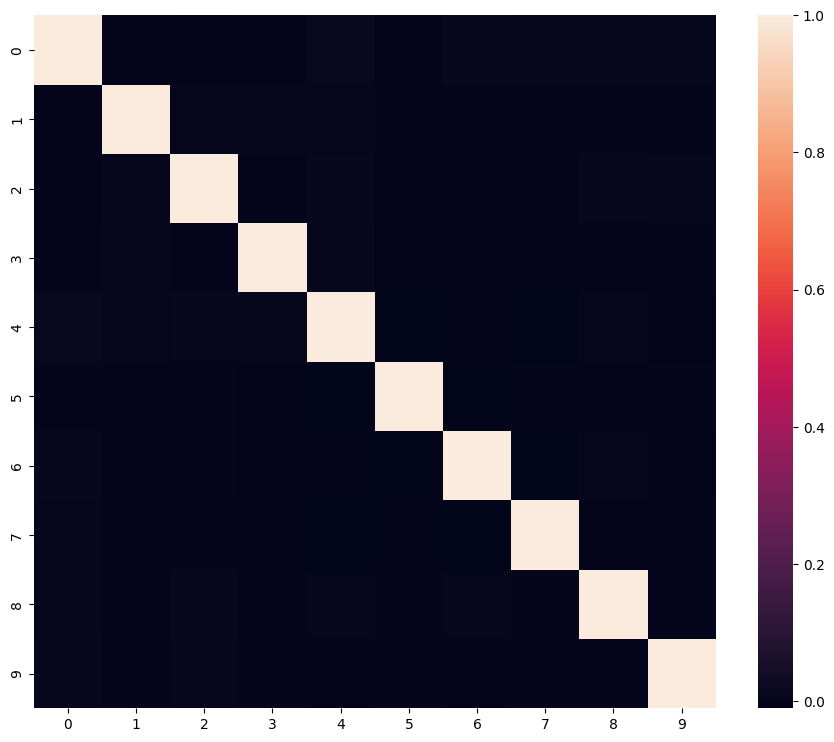

In [27]:
# validation results
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import palettable

plt.figure(figsize=(11, 9),dpi=100)
sns.heatmap(data=corr_mean,
           )

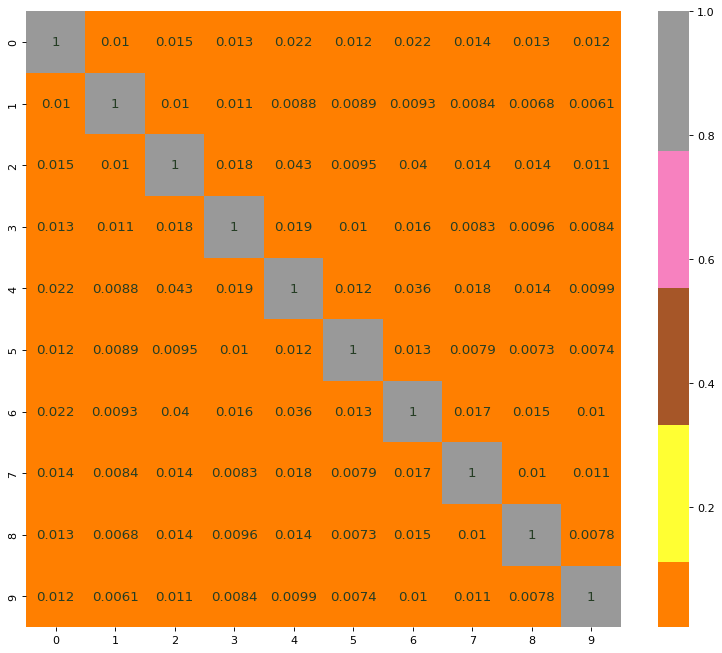

In [28]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    corr_abs_mean,
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

In [29]:
np.sum(corr_abs_mean)-10

1.2417010823264718

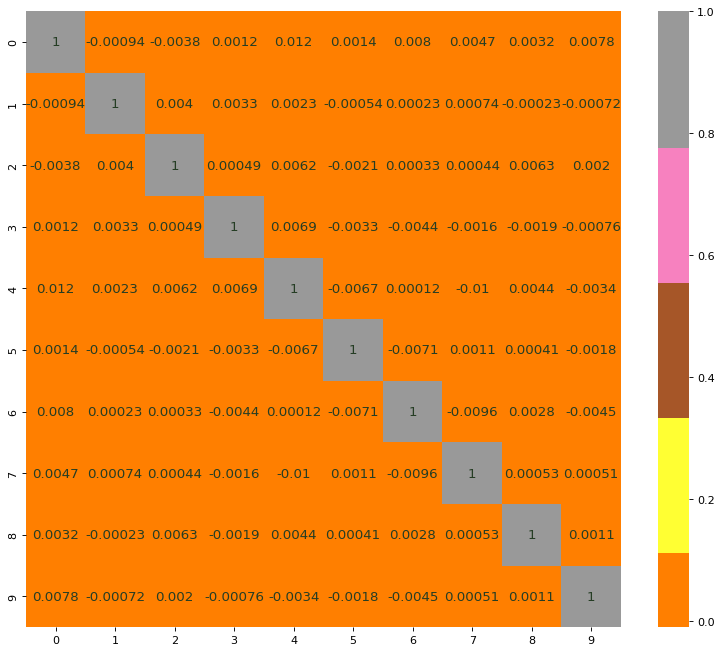

In [30]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    corr_mean,
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

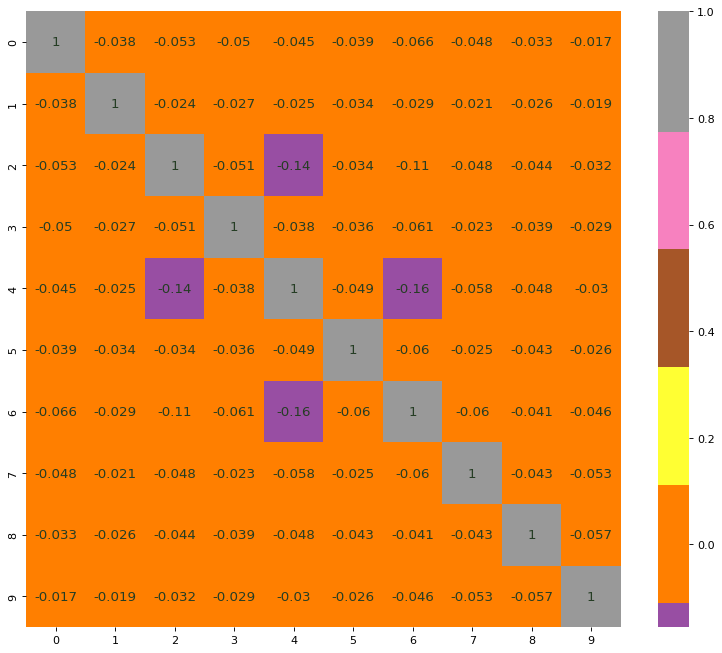

In [31]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    corr_min,
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

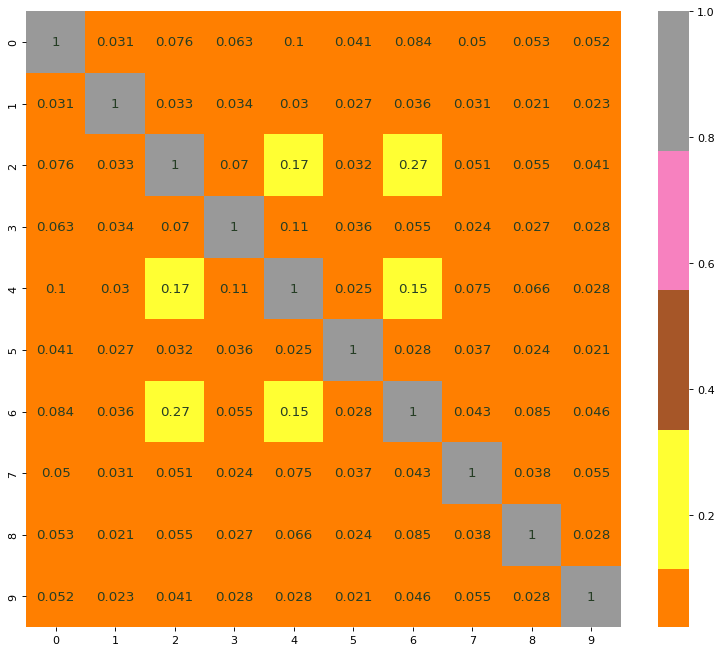

In [32]:
plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    corr_max,
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

In [33]:
np.save('FMNIST-normal-acc-label'+str(LABEL)+'-repeat.npy',acc_record)
np.save('FMNIST-normal-radius-label'+str(LABEL)+'-repeat.npy',r_records)
np.save('FMNIST-normal-corr-label'+str(LABEL)+'-repeat.npy',corr_whole)
# only need to save because we only train netD
torch.save(netD, 'Final_FMNIST_normal_NetD-label'+str(LABEL)+'-repeat.pth')
#torch.save(netV, 'MNIST_NetV-mode1-radius2-makeup.pth')
#torch.save(netG, 'MNIST_NetG-mode1-radius2-makeup.pth')

extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.46it/s]


----------------------------
Train_z, Test_z
PCA: 0.8190999999999999
SVD: 0.8231999999999999
NetG_fixDwith radius 0 0.8566
0 0.8566
0.14007685307296924 1.264507433399558 -4.544173691421747 5.235293589532375


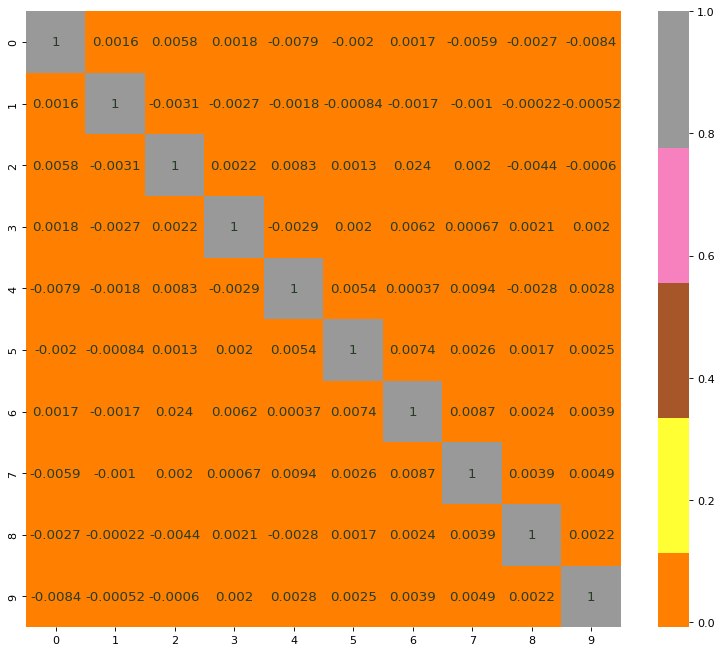

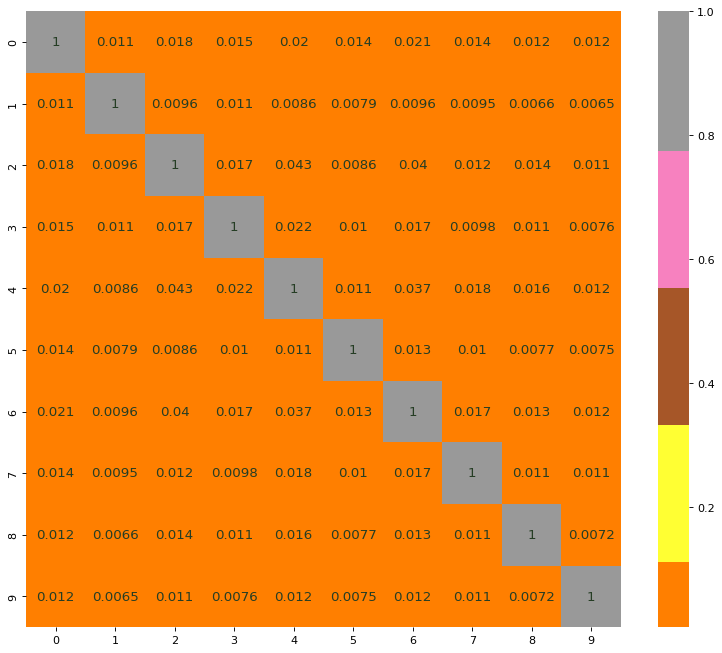

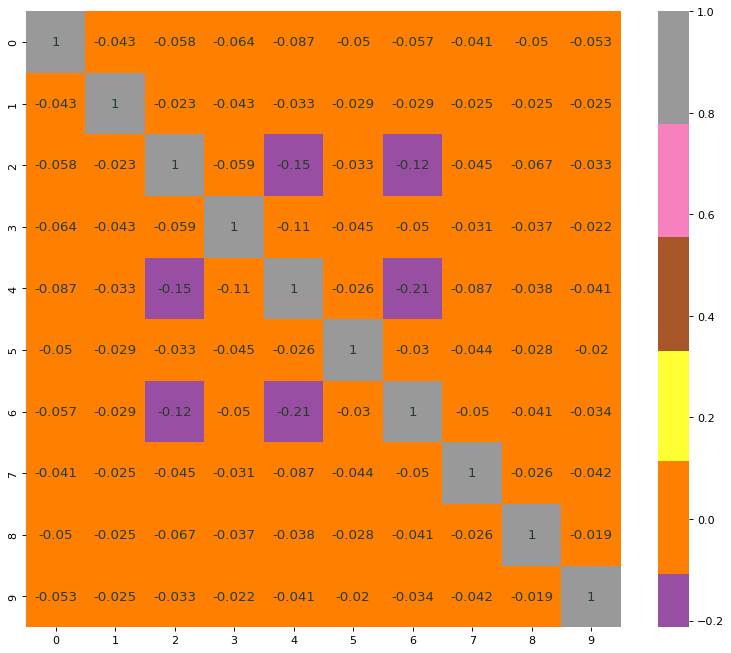

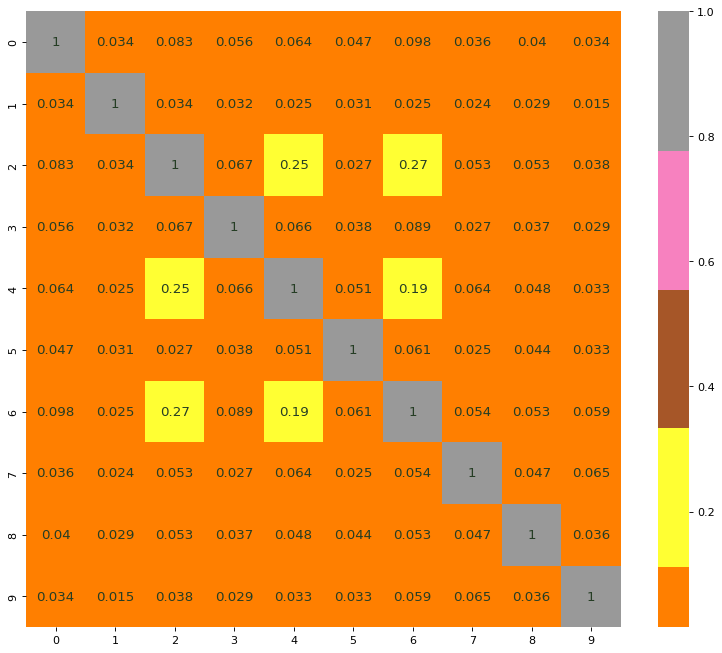

In [34]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.41it/s]


----------------------------
Train_z, Test_z
PCA: 0.8194
SVD: 0.8236
NetG_fixDwith radius 9.951441664900494e-05 0.8567
9.951441664900494e-05 0.8567
0.1400619863998145 1.264502728357911 -4.5442348048090935 5.235191151499748


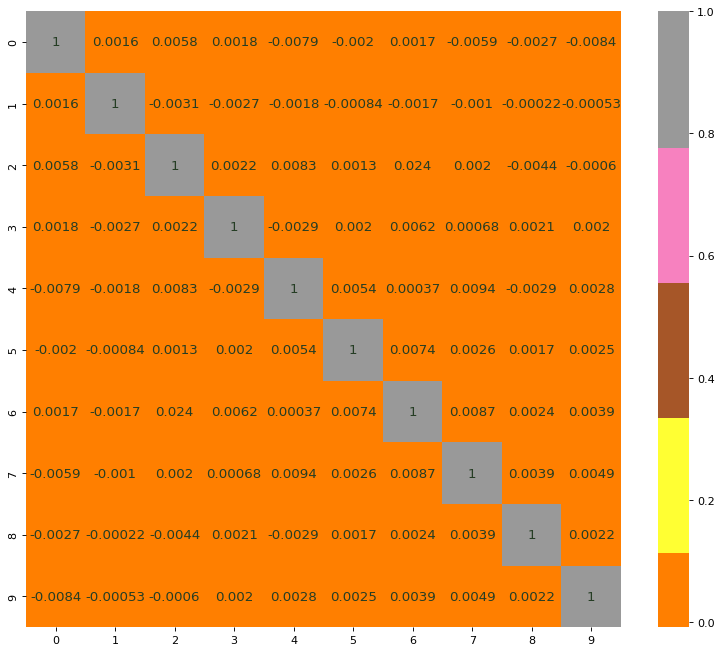

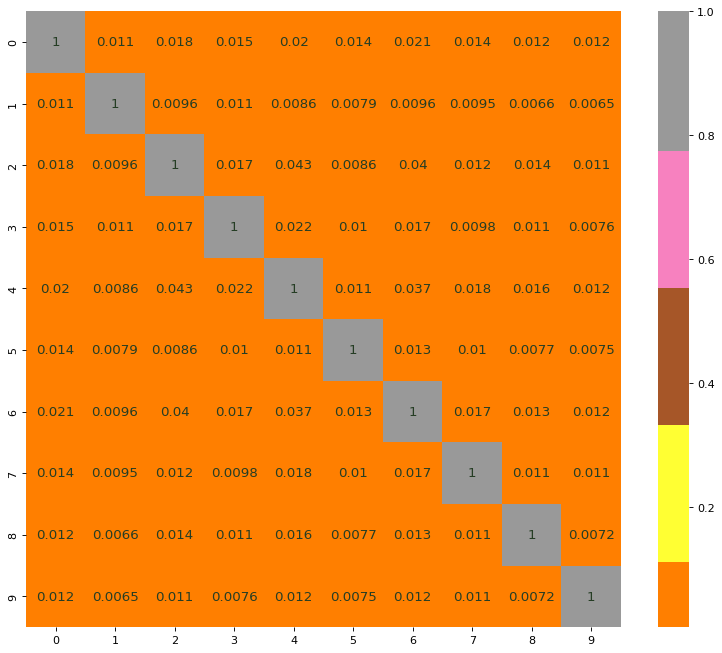

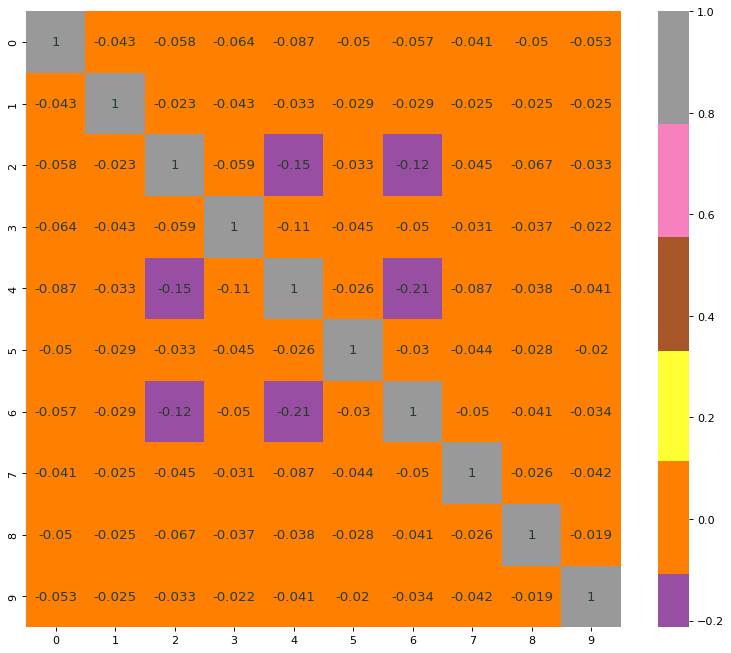

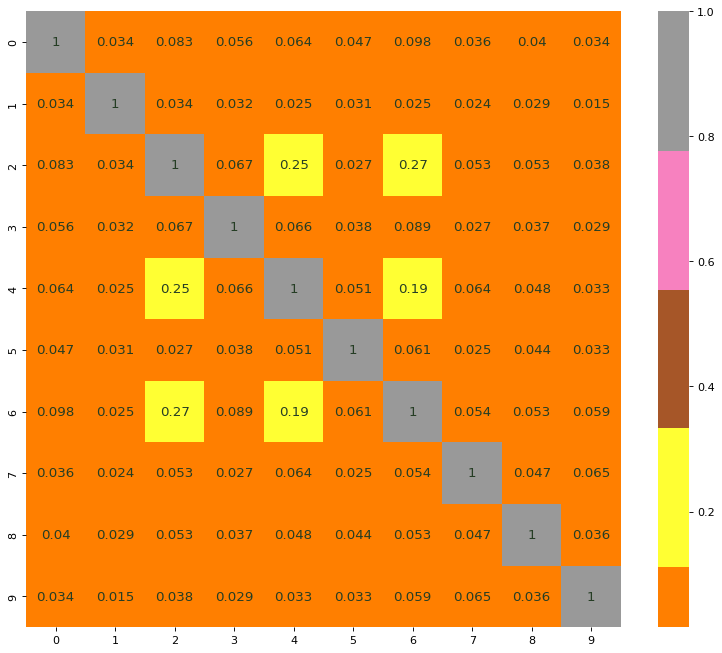

In [35]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.8199
SVD: 0.8234
NetG_fixDwith radius 0.00046746172364778066 0.8566
0.00046746172364778066 0.8566
0.14010157229495235 1.26452727150172 -4.543884597718716 5.23476804420352


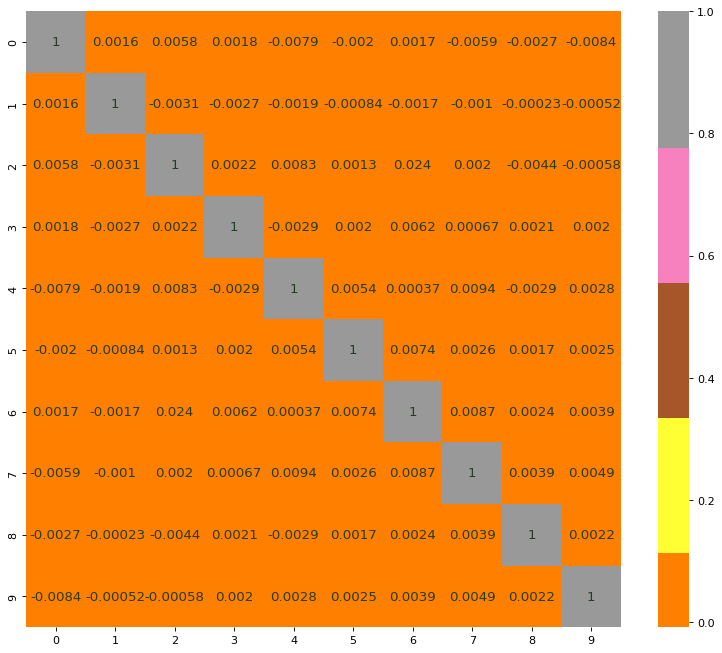

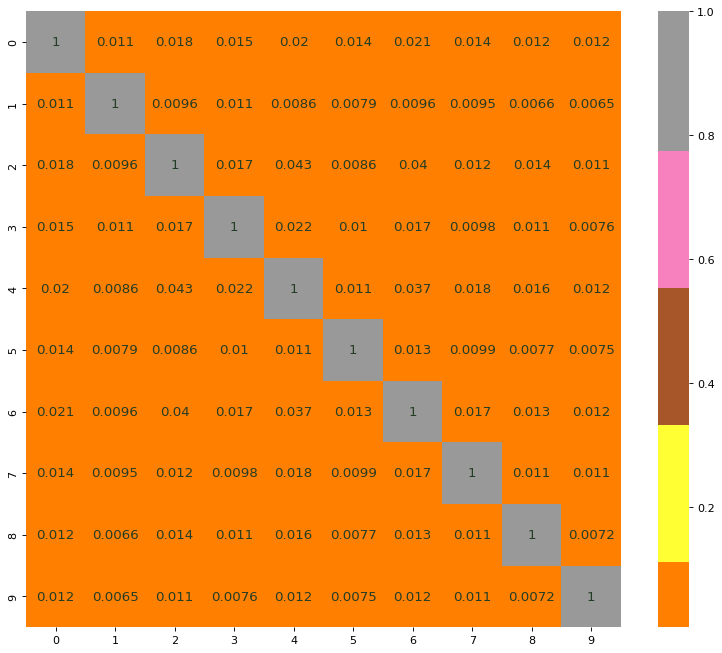

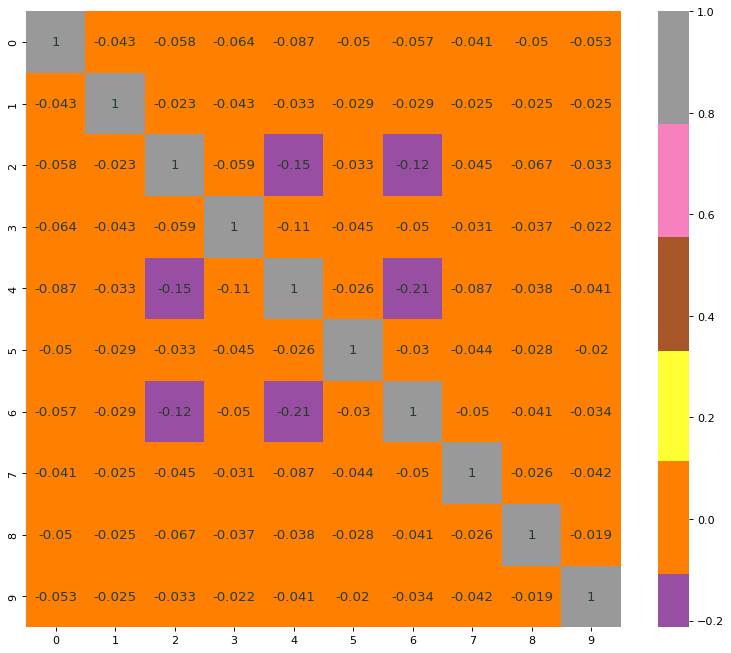

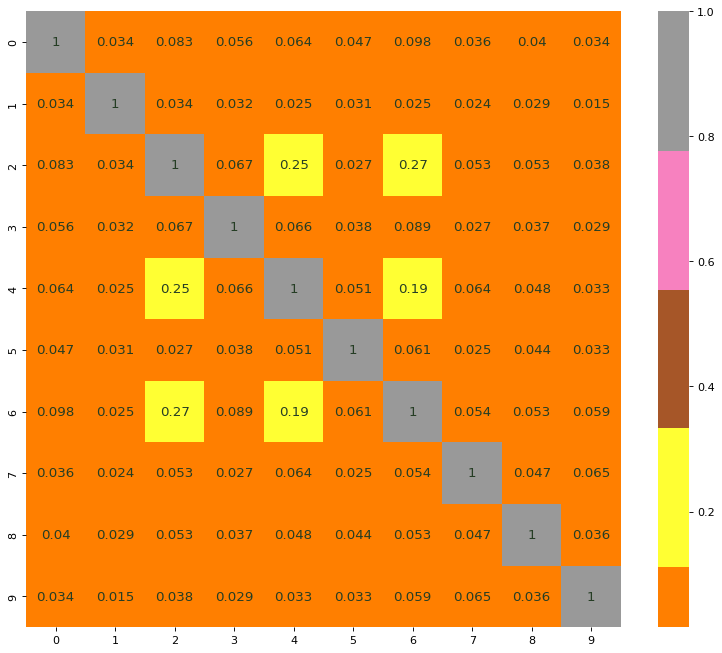

In [36]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.44it/s]


----------------------------
Train_z, Test_z
PCA: 0.8212
SVD: 0.8217
NetG_fixDwith radius 0.2056433427128647 0.8573
0.2056433427128647 0.8573
0.19601619116292568 1.4956300724297762 -5.208151280879974 5.762843452394009


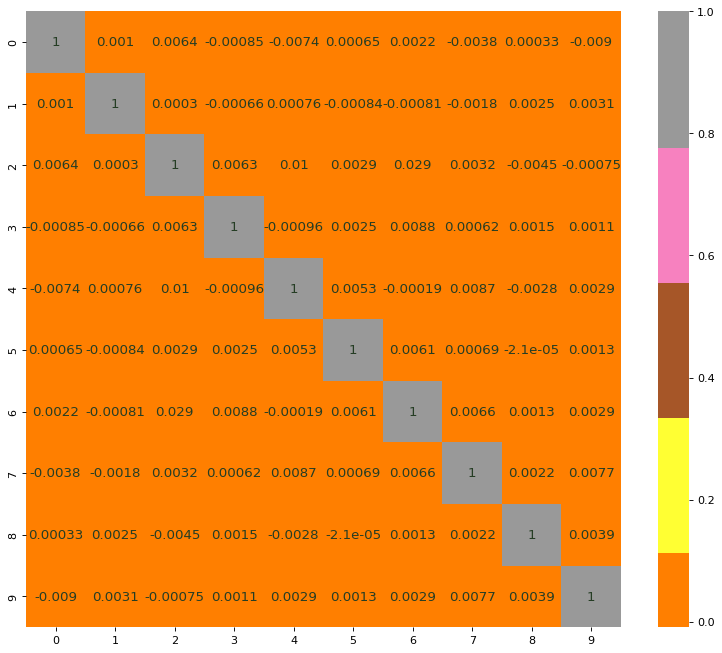

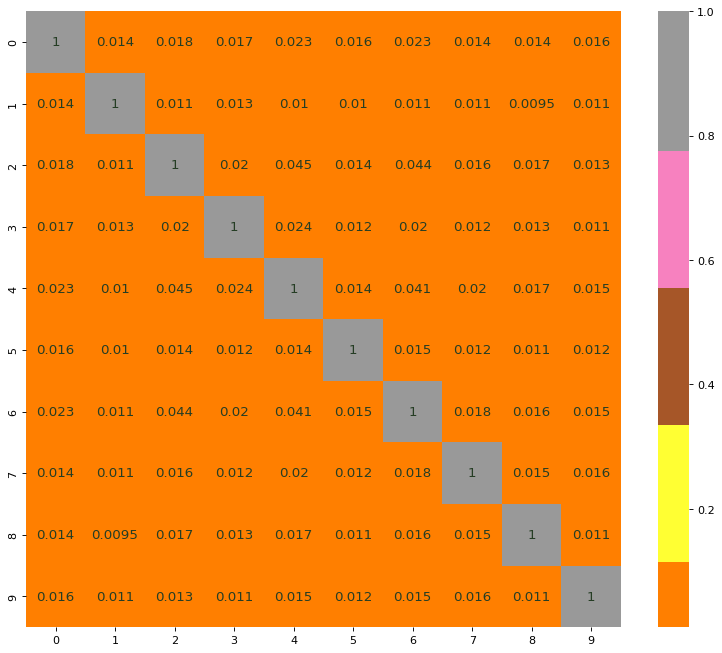

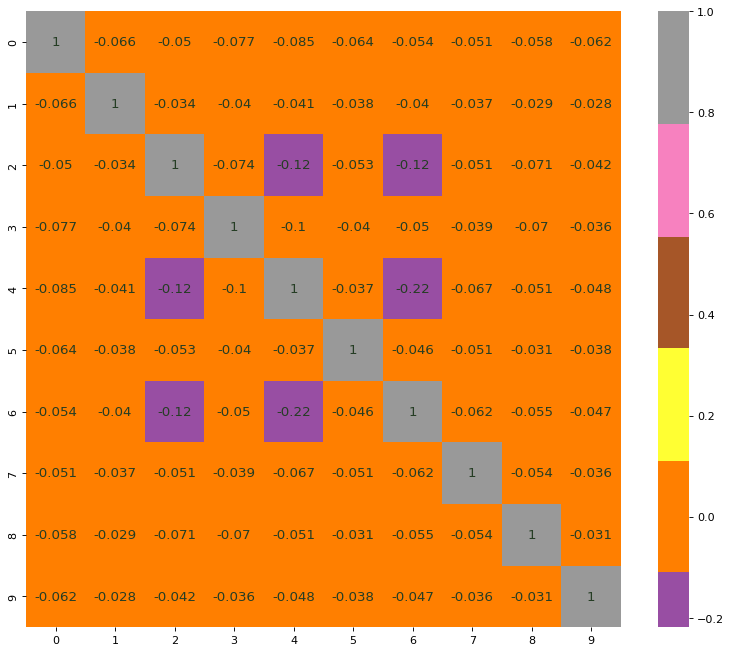

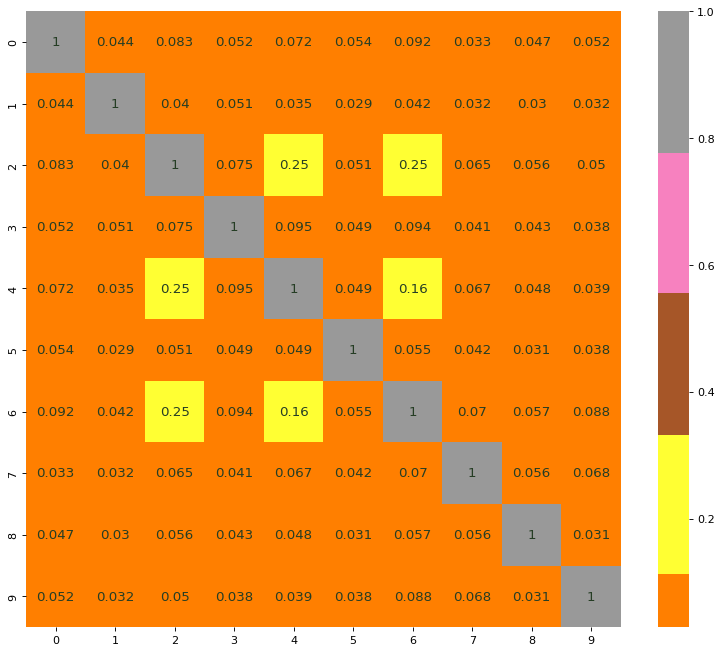

In [37]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.42it/s]


----------------------------
Train_z, Test_z
PCA: 0.8196
SVD: 0.8231999999999999
NetG_fixDwith radius 0.000326882565235828 0.8567
0.000326882565235828 0.8567
0.14016628931858577 1.2645547110587358 -4.544132836163044 5.235512603074312


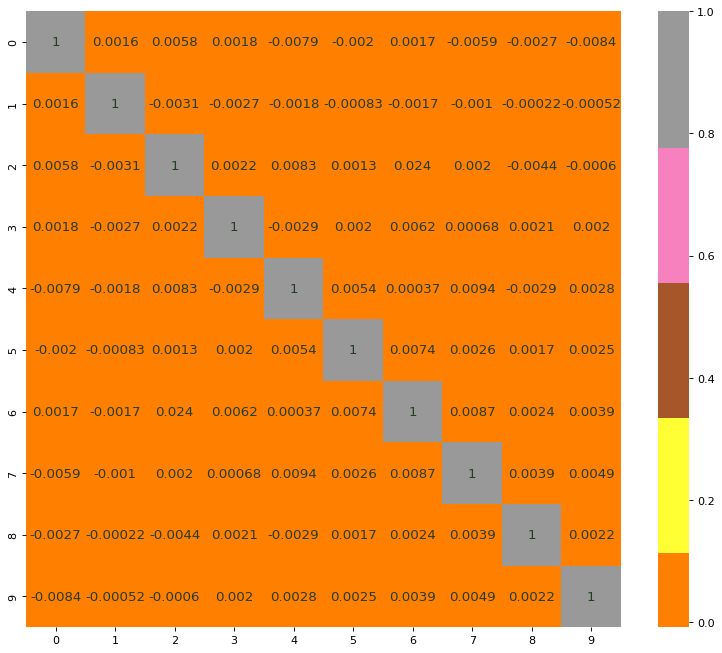

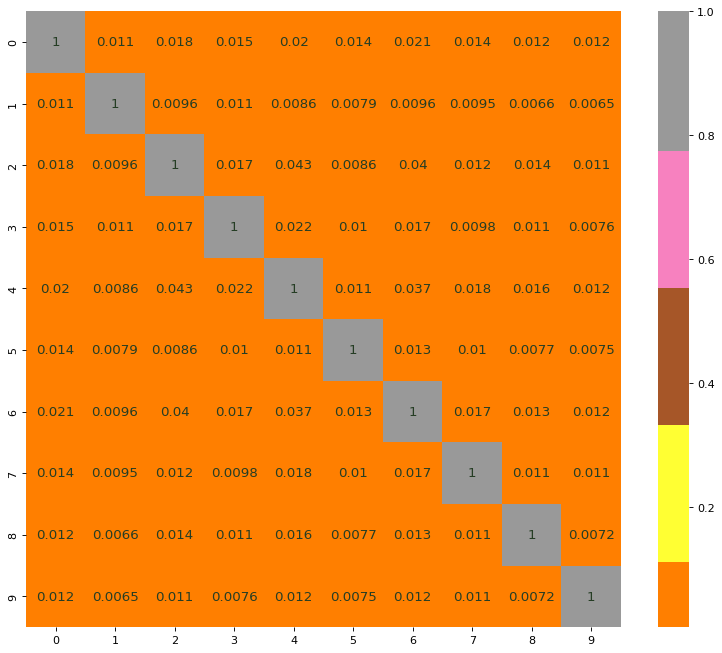

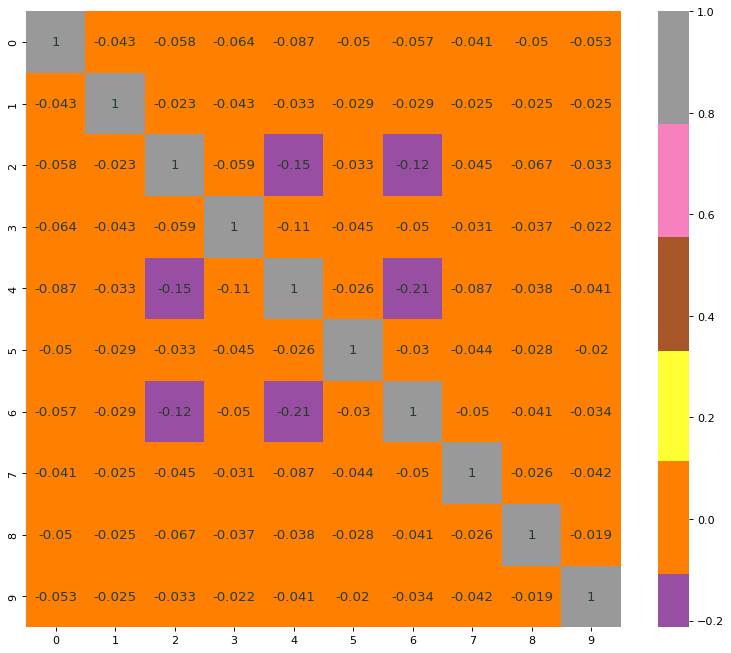

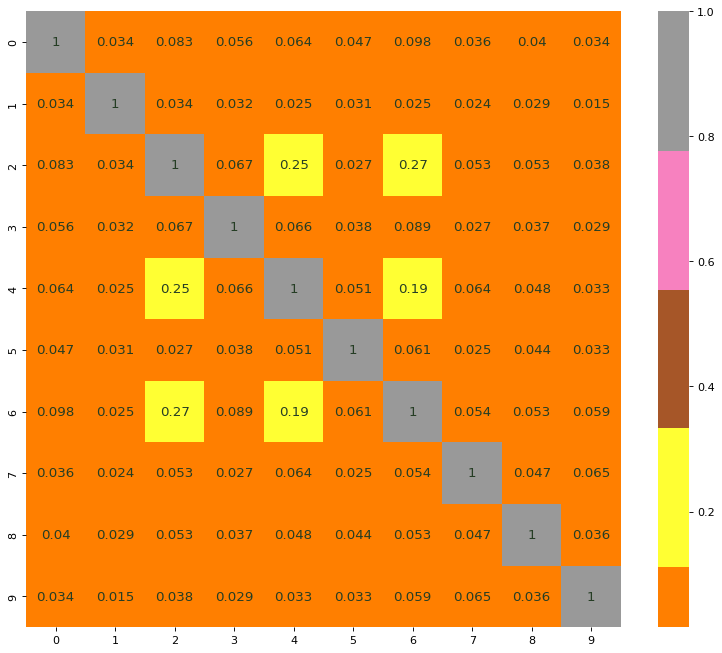

In [38]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


----------------------------
Train_z, Test_z
PCA: 0.8205
SVD: 0.8233
NetG_fixDwith radius 0.15034746530126641 0.8568
0.15034746530126641 0.8568
0.15415912389289588 1.4430169761180878 -4.990885559469461 5.65969630330801


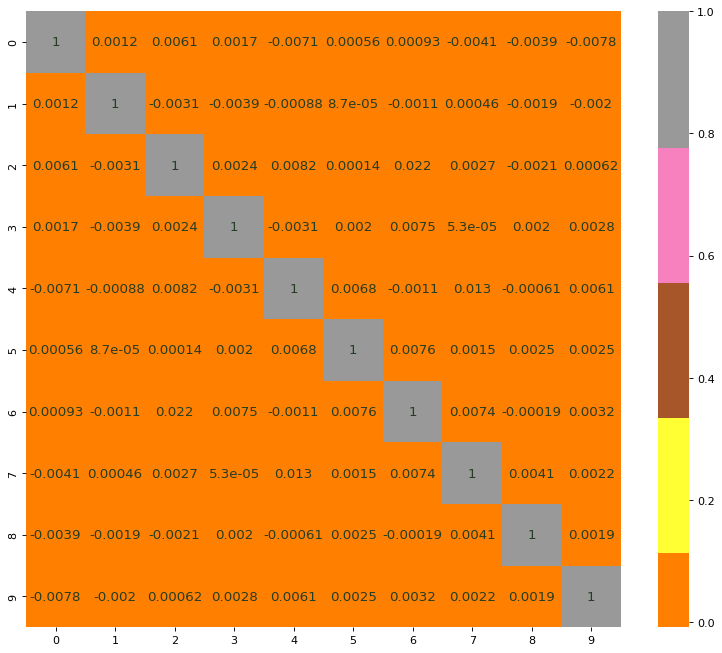

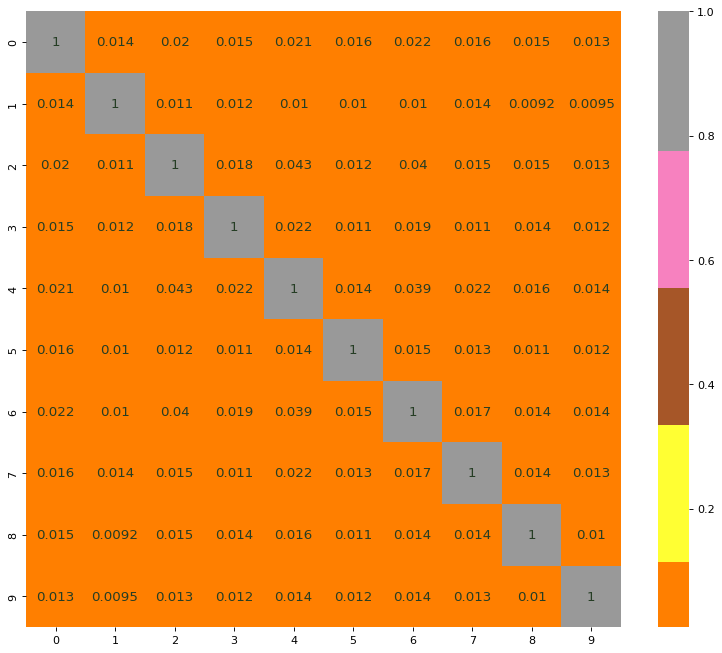

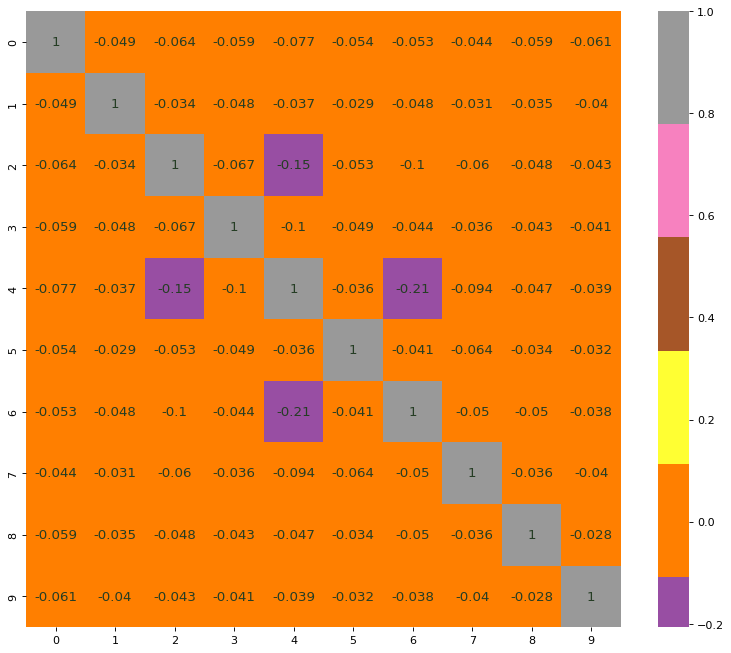

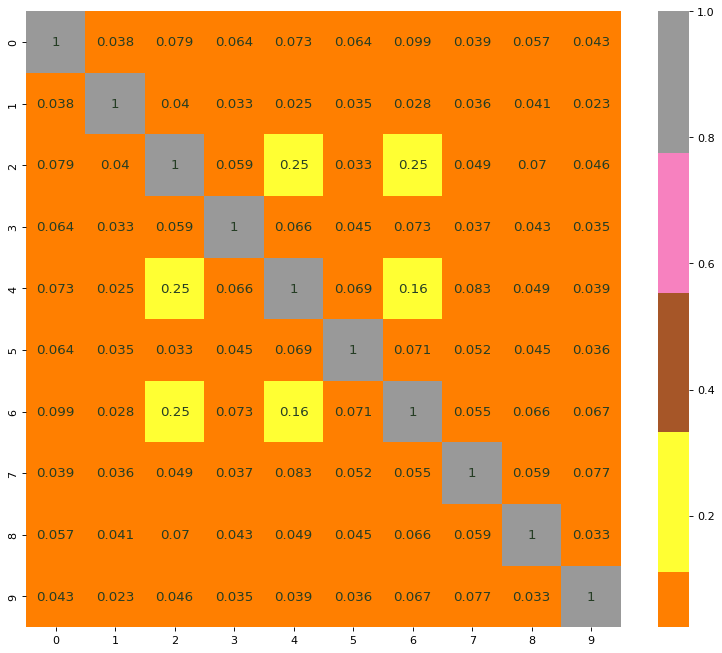

In [39]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8195
SVD: 0.8234
NetG_fixDwith radius 1.8478213938906724e-06 0.8566
1.8478213938906724e-06 0.8566
0.14007723893155344 1.2645079186186194 -4.5441757664084435 5.235294610261917


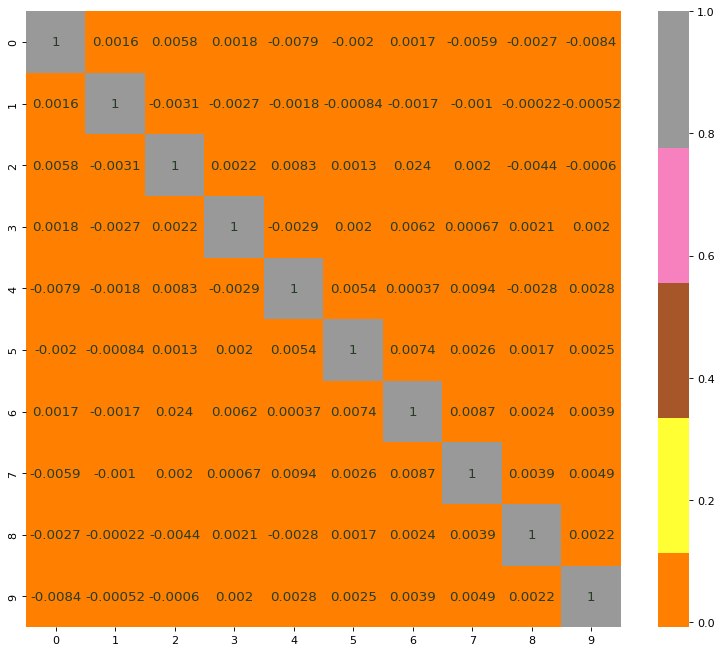

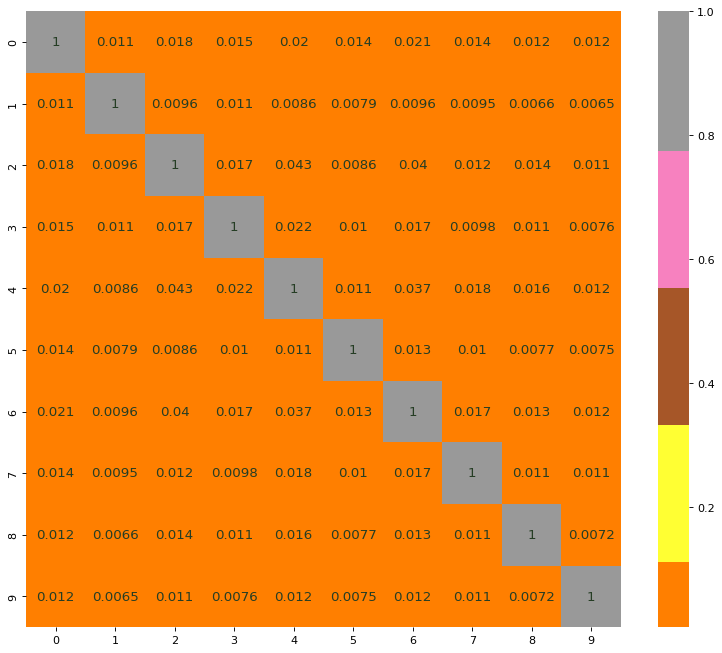

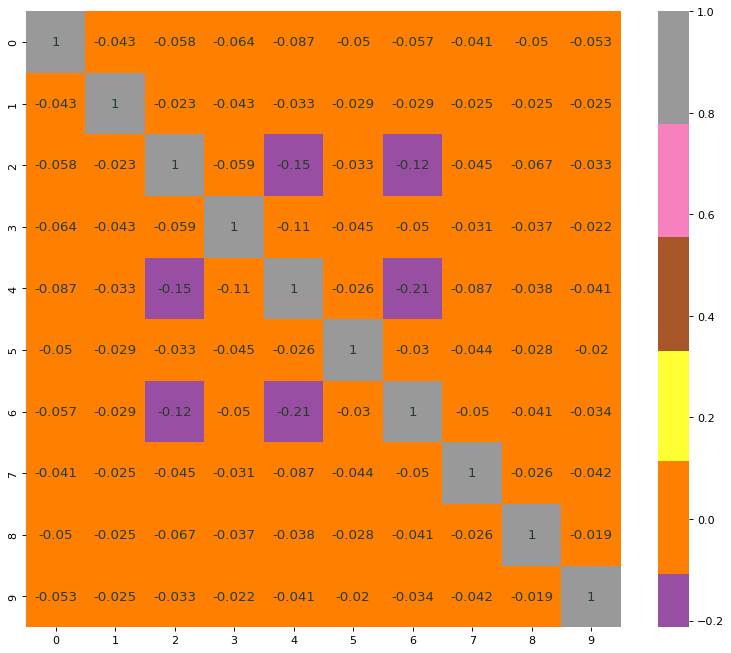

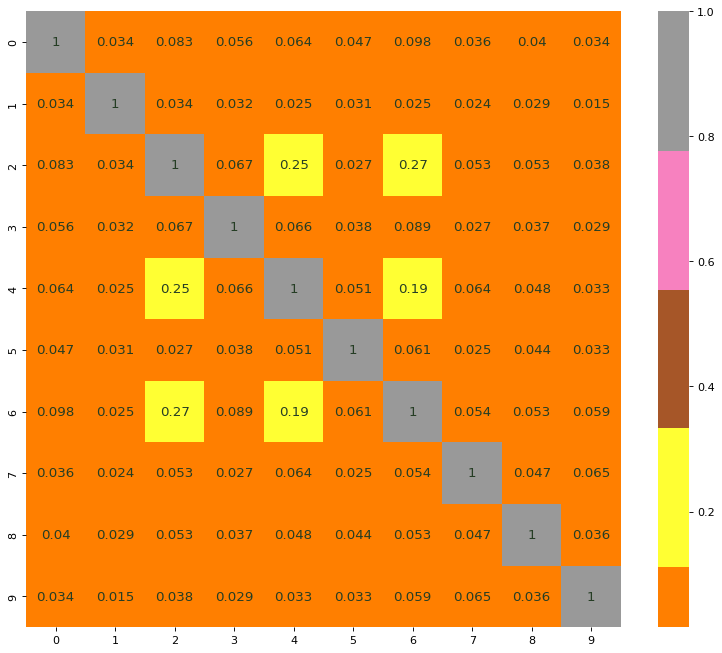

In [40]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


----------------------------
Train_z, Test_z
PCA: 0.8209
SVD: 0.8234
NetG_fixDwith radius 0.08441136659640773 0.8581
0.08441136659640773 0.8581
0.11998946483436157 1.3348144125193357 -4.8703692108392715 5.403529077768326


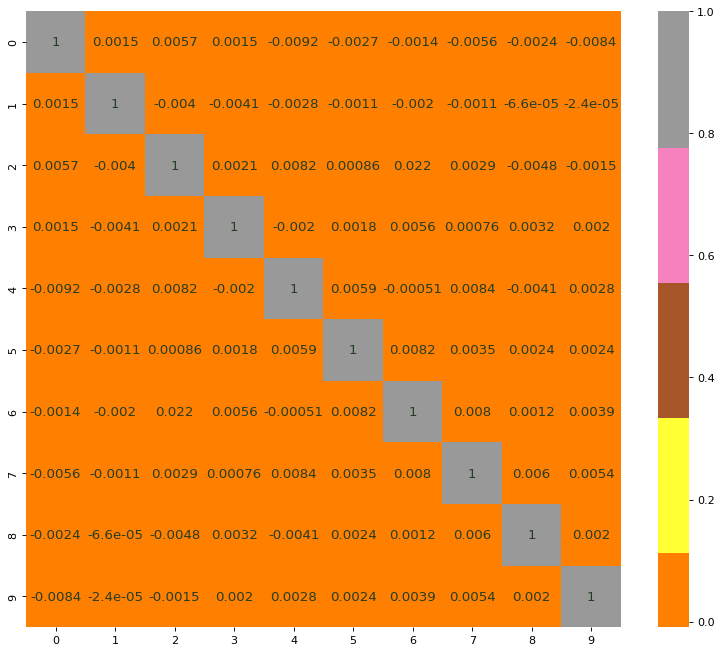

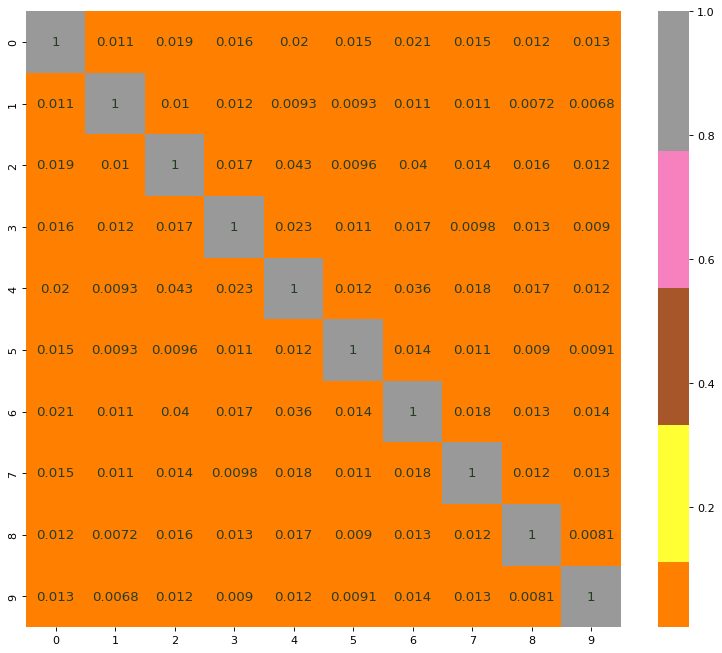

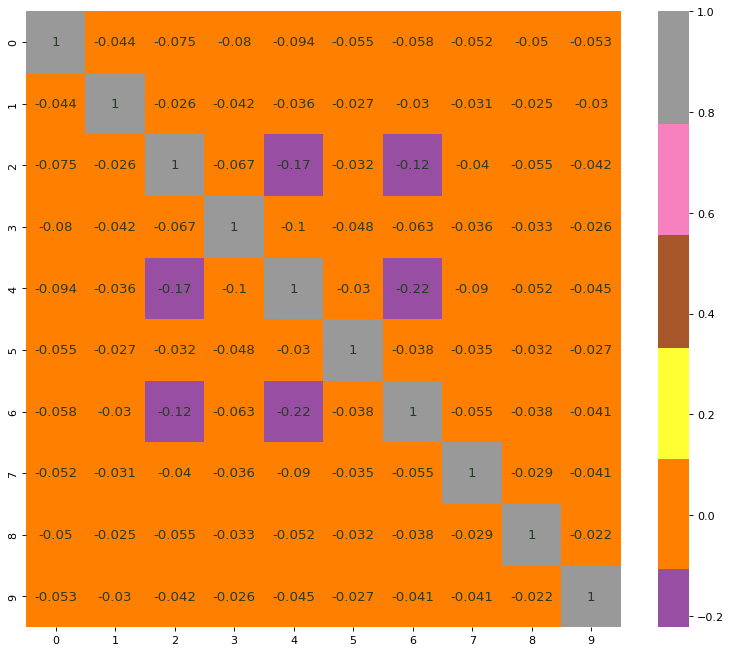

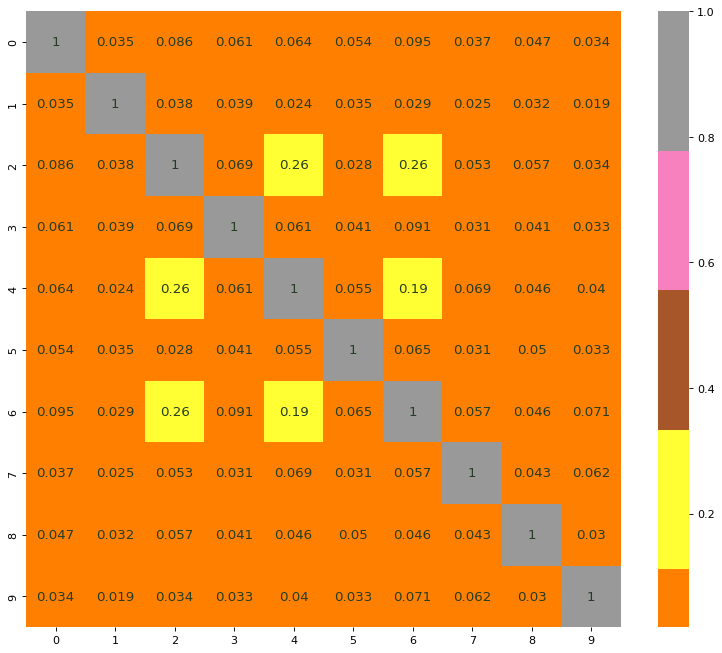

In [41]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



extracting all features from dataset: 100%|██████████████████████████████████████████████| 1/1 [00:00<00:00,  1.45it/s]


----------------------------
Train_z, Test_z
PCA: 0.819
SVD: 0.8222
NetG_fixDwith radius 0.15479750335014555 0.8576
0.15479750335014555 0.8576
0.16242486258852296 1.4549636915326118 -5.280866663902998 5.636250242590904


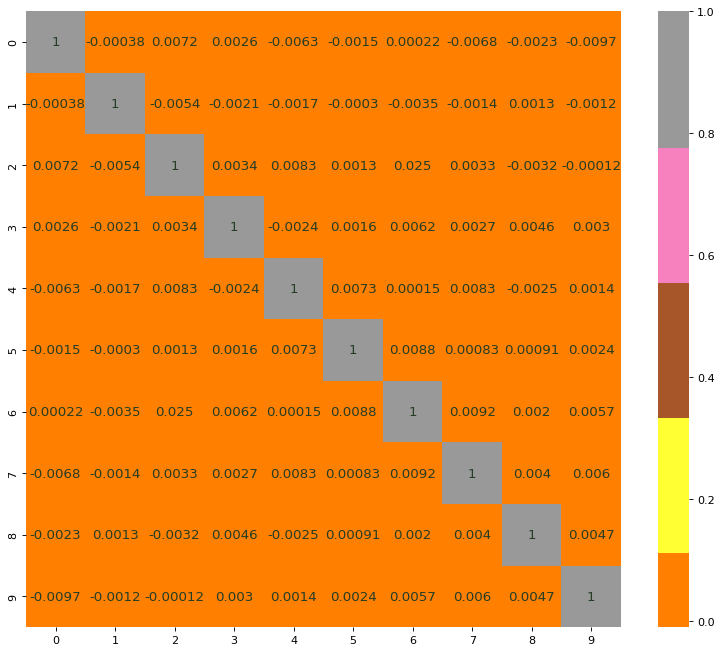

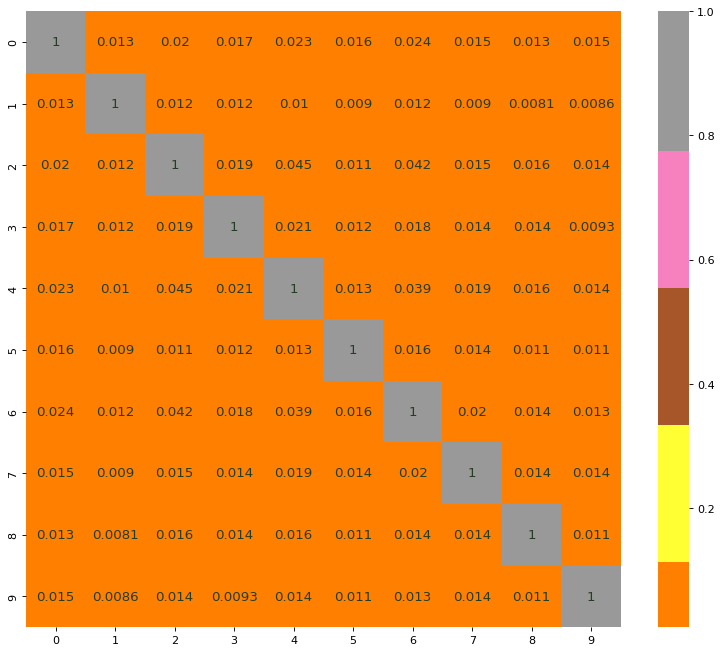

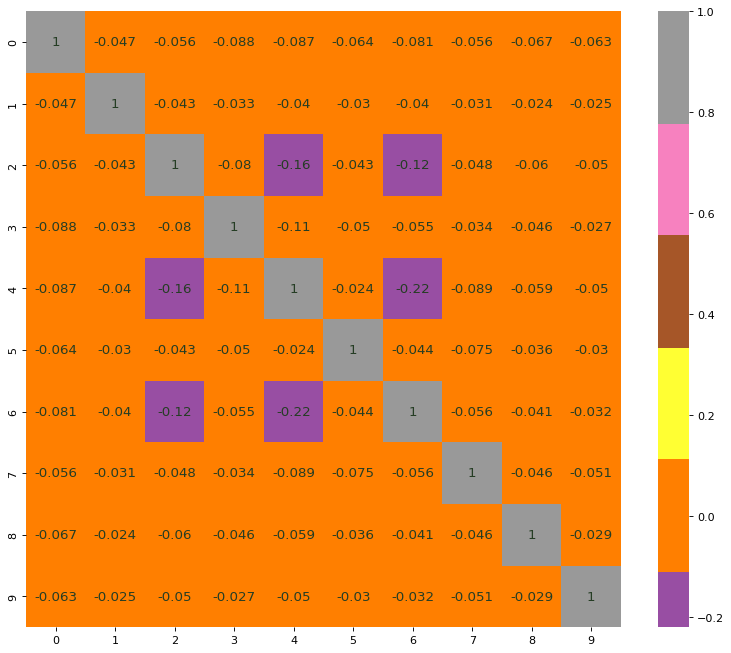

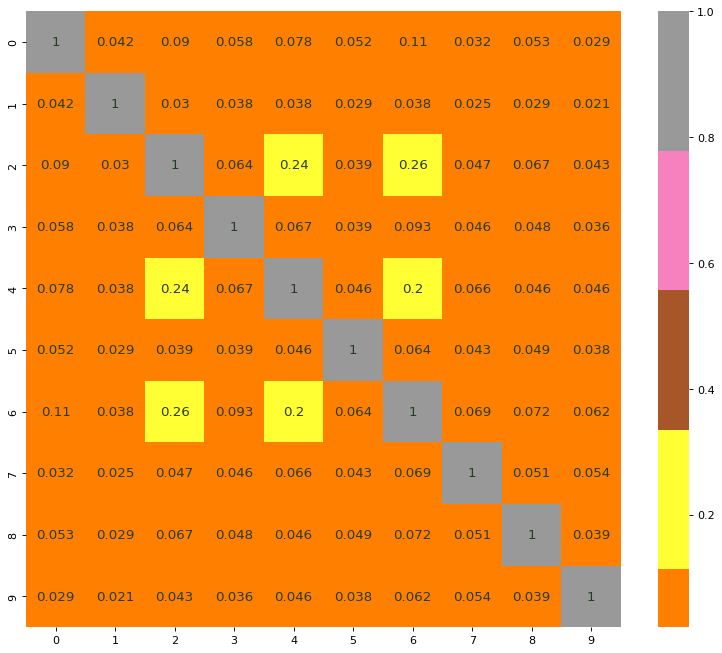

In [42]:
# test netG correlation and radius
test_r1,test_r2,test_corr,acc_val = gs_radius_val(radius1=0,radius2=100,netD=netD,real_cpu=real_cpu,real_label=real_label,tor=1e-5,n_dis=2,lam=0.618,mode=1)
print(test_r1,acc_val)
print(np.sum(test_corr[0:10])-10,np.sum(test_corr[10:20])-10,np.sum(test_corr[20:30])-10,np.sum(test_corr[30:40])-10)

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[0:10],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[10:20],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()

plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[20:30],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()


plt.figure(figsize=(12, 10), dpi=80)
sns.heatmap(
    test_corr[30:40],
    cmap='Set1',
    center=0,
    annot=True,
    annot_kws={
        'size': 12,
        'weight': 'normal',
        'color': '#253D24'
    },
)
plt.show()



In [43]:
acc_record

array([[8.59500000e-01, 8.57365000e-01, 8.57010000e-01, 8.56530000e-01,
        8.51825000e-01, 8.37325000e-01, 7.14755000e-01, 3.53195000e-01,
        1.35765000e-01, 1.01880000e-01, 1.03845000e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.59500000e-01, 8.58700000e-01, 8.58600000e-01, 8.58800000e-01,
        8.53400000e-01, 8.39800000e-01, 7.85900000e-01, 4.90800000e-01,
        1.85100000e-01, 1.33900000e-01, 1.38200000e-01, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [8.59500000e-01, 8.56100000e-01, 8.55800000e-01, 8.54400000e-01,
        8.49300000e-01, 8.29800000e-01, 5.65500000e-01, 1.78900000e-01,
        9.42000000e-02, 6.06000000e-02, 6.61000000e-02, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.0000